# Pierce - Pathway Analysis
Author: Leo Joseph (l1joseph@ucsd.edu)
The purpose of the notebook is to perform pathway  analysis on ASD versus TD samples.

In [1]:
# qiime2 imports
import qiime2 as q2
from qiime2 import Artifact, Metadata, Visualization
from qiime2.plugins.feature_table.methods import filter_features, filter_samples

# birdman imports
import biom
import pandas as pd
import numpy as np

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



## Load Artifacts

In [2]:
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')
ko_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195334_ko.zebra.tp-td.biom')
ko = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195334_ko.zebra.biom')
pathway = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195331_pathway.zebra.tp-td.biom')


md = Metadata.load('/home/lpatel/projects/2024-03-04_pierce-autism/qiita/15350_20240110-175840_noblanks.txt')
info = pd.read_csv('/home/lpatel/projects/2024-03-04_pierce-autism/ref/tryptophan_kegg.tsv', sep='\t', index_col=0)



In [3]:
# Assuming `info` is a DataFrame that contains the "EC" column
# And `ec` is the BIOM table loaded from 'out/195333_ec.zebra.biom'

# Convert the EC column values to a set for faster lookup
ec_info_values = set(info["EC"].values)

# Get the observation IDs from the BIOM table `ec`
ec_observation_ids = set(ec.ids(axis='observation'))

# Find the overlap
overlap = ec_info_values.intersection(ec_observation_ids)

# Display the overlap
print(f"Number of overlapping items: {len(overlap)}")
print(f"Overlapping items: {overlap}")


Number of overlapping items: 7
Overlapping items: {'1.4.3.4', '3.7.1.3', '3.5.1.9', '1.13.11.11', '1.13.11.6', '1.14.16.1', '4.1.1.28'}


In [4]:
info

,Other Name,K0/ortholog,EC,Tryptophan Pathway
Name,,,,
"tryptophan 2,3-dioxygenase","TDO2, kynA",K00453,1.13.11.11,kynurinine
"indoleamine 2,3-dioxygenase",IDO,K00463,1.13.11.52,kynurinine
arylformamidase,kynB,K07130,3.5.1.9,kynurinine
kynureninase,kynU,K01556,3.7.1.3,kynurinine
CCBL,NaN,K00816,2.6.1.7,kynurinine
kynurenine/2-aminoadipate aminotransferase,"AADAT, KAT2",K00825,2.6.1.7,kynurinine
kynurenine aminotransferase,BNA3,K14264,2.6.1.7,kynurinine
kynurenine 3-monooxygenase,KMO,K00486,1.14.13.9,kynurinine
"3-hydroxyanthranilate 3,4-dioxygenase",HAAO,K00452,1.13.11.6,kynurinine


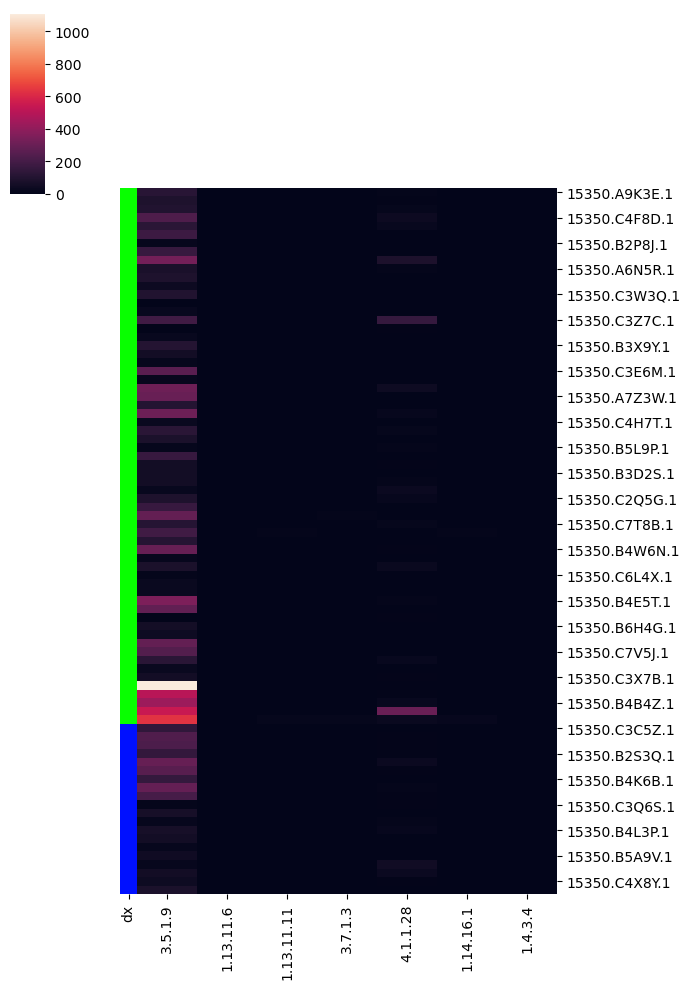

In [5]:
import biom
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, leaves_list

# Load BIOM tables from the given paths
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')

# Assuming `info` and `md` are already loaded as DataFrames
# Replace these with your actual data loading if necessary
# info = pd.read_csv('path_to_info.csv')
# md = pd.read_csv('path_to_metadata.csv')

# Convert the EC column values to a set for faster lookup
ec_info_values = set(info["EC"].values)

# Get the observation IDs from the BIOM table `ec`
ec_observation_ids = set(ec.ids(axis='observation'))

# Find the overlap
overlap = ec_info_values.intersection(ec_observation_ids)

# Filter the `ec` table to include only the overlapping observations
filtered_ec = ec.filter(overlap, axis='observation', inplace=False)

# Convert the filtered BIOM table to a DataFrame
filtered_ec_df = filtered_ec.to_dataframe(dense=True).T

# Group samples by the "dx" column from the metadata
metadata_df = md.to_dataframe()
grouped_samples = metadata_df["dx"].loc[filtered_ec_df.index]

# Sort rows by 'dx'
sorted_metadata_df = metadata_df.loc[filtered_ec_df.index].sort_values('dx')
sorted_filtered_ec_df = filtered_ec_df.loc[sorted_metadata_df.index]

# Define clusters for rows (samples) within each 'dx' group
def cluster_within_groups(df, group_labels):
    sorted_idx = []
    unique_groups = group_labels.unique()
    for group in unique_groups:
        group_idx = group_labels[group_labels == group].index
        group_data = df.loc[group_idx]
        if len(group_idx) > 1:  # Only cluster if there's more than one sample
            kmeans = KMeans(n_clusters=2, random_state=0).fit(group_data)
            sorted_idx.extend(group_idx[np.argsort(kmeans.labels_)])
        else:
            sorted_idx.extend(group_idx)
    return sorted_idx

row_clusters = cluster_within_groups(sorted_filtered_ec_df, sorted_metadata_df["dx"])

# Group columns by 'Tryptophan Pathway' and sort within each group
grouped_columns = info.set_index('EC').loc[filtered_ec_df.columns, "Tryptophan Pathway"]
unique_pathways = grouped_columns.unique()

sorted_col_idx = []
for pathway in unique_pathways:
    pathway_cols = grouped_columns[grouped_columns == pathway].index
    pathway_data = filtered_ec_df[pathway_cols]
    if len(pathway_cols) > 1:  # Only cluster if there's more than one column
        col_linkage = linkage(pathway_data.T, method='ward')
        sorted_col_idx.extend(pathway_cols[leaves_list(col_linkage)])
    else:
        sorted_col_idx.extend(pathway_cols)

# Reorder the DataFrame using .loc for label-based indexing
reordered_df = sorted_filtered_ec_df.loc[row_clusters, sorted_col_idx]

# Relabel the x-axis using the original index names from info
info_indexed = info.set_index('EC')
column_labels = info_indexed.loc[reordered_df.columns].index
reordered_df.columns = column_labels

# Map the "dx" column to colors
unique_dx = sorted_metadata_df["dx"].unique()
color_palette = sns.color_palette("hsv", len(unique_dx))
dx_colors = dict(zip(unique_dx, color_palette))
row_colors = sorted_metadata_df["dx"].map(dx_colors).loc[row_clusters]

# Generate the cluster map
sns.clustermap(reordered_df, row_cluster=False, col_cluster=False, figsize=(7, 10), row_colors=row_colors)
plt.show()


### Log-Transform

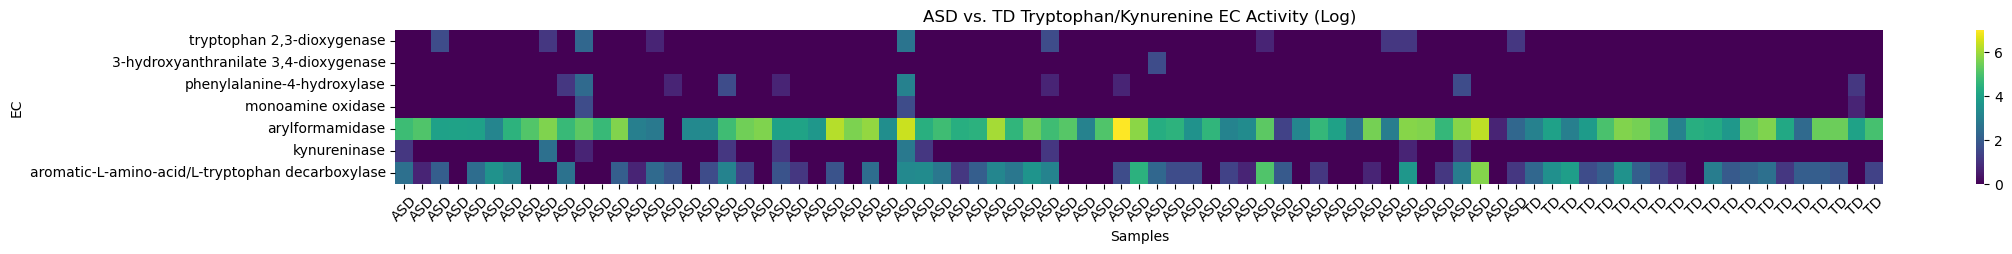

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Log-transform the data to handle zeros
logged_df = np.log1p(sorted_filtered_ec_df)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(logged_df.columns)].index

# Retrieve the 'dx' values for the rows
row_labels = metadata_df.loc[logged_df.index, 'dx']

# Ensure the order of column labels matches the logged_df columns
column_labels = [info[info['EC'] == col].index[0] for col in logged_df.columns]

# Transpose the DataFrame for the heatmap
transposed_logged_df = logged_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_logged_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)

plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (Log)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

<Figure size 1000x800 with 0 Axes>

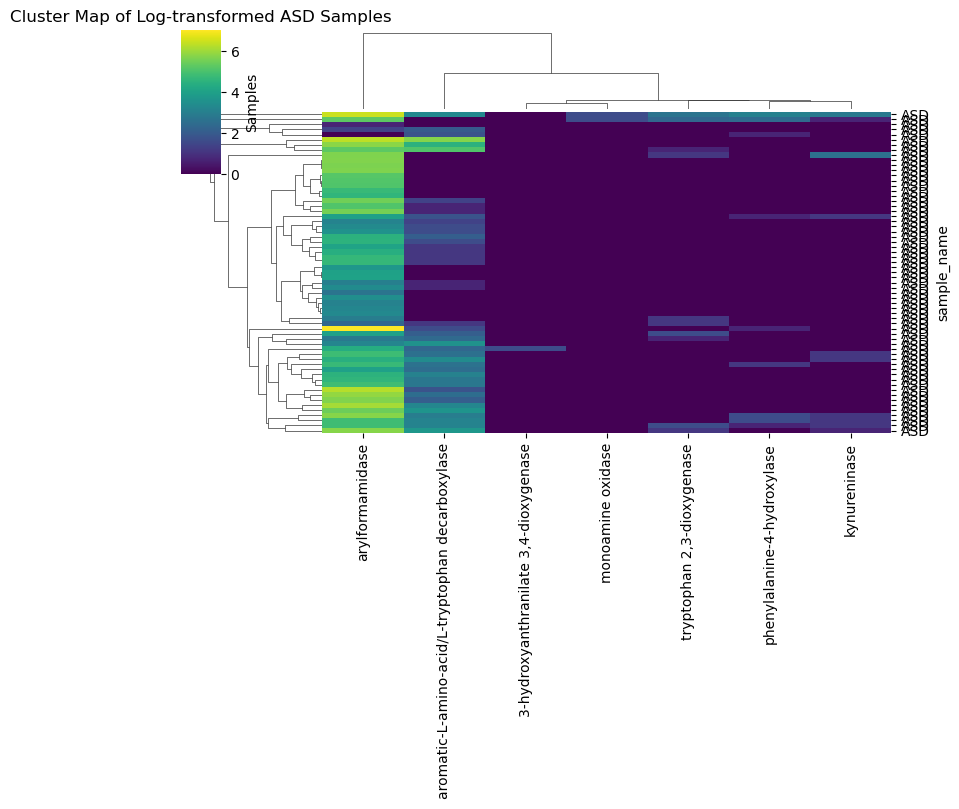

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Log-transform the filtered data to handle zeros
logged_df_asd = np.log1p(filtered_ec_df_asd)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = [info[info['EC'] == col].index[0] for col in logged_df_asd.columns]

# Retrieve the 'dx' values for the rows (though they should all be "ASD" now)
row_labels = metadata_df.loc[logged_df_asd.index, 'dx']

# Create the cluster map with annotations
plt.figure(figsize=(10, 8))  # Adjusted figure size for the cluster map
sns.clustermap(logged_df_asd, cmap="viridis", cbar=True,
               xticklabels=column_labels, yticklabels=row_labels, figsize=(8, 8))

plt.title("Cluster Map of Log-transformed ASD Samples")
plt.xlabel("EC")
plt.ylabel("Samples")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


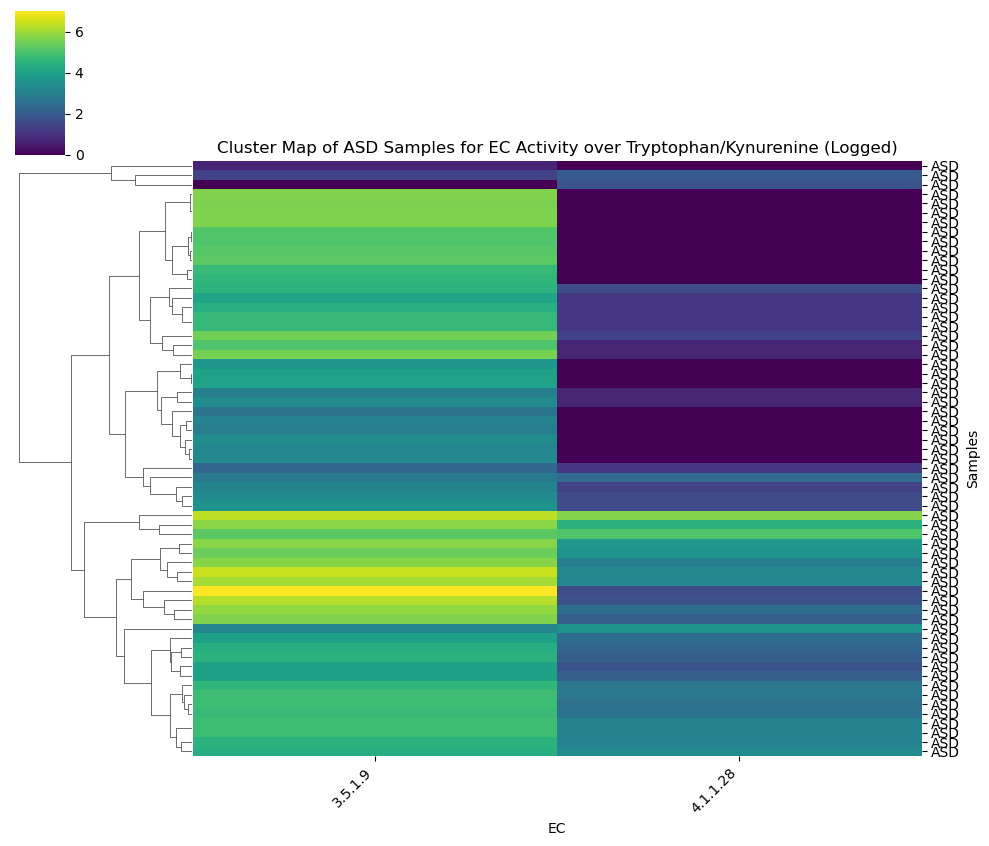

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Filter for just the specific EC values
specific_ec_values = ["3.5.1.9", "4.1.1.28"]
filtered_ec_df_asd_specific = filtered_ec_df_asd[specific_ec_values]

# Log-transform the filtered data to handle zeros
logged_df_asd_specific = np.log1p(filtered_ec_df_asd_specific)

# Retrieve the 'dx' values for the rows (though they should all be "ASD" now)
row_labels = metadata_df.loc[logged_df_asd_specific.index, 'dx']

# Create the cluster map with annotations
cluster_map = sns.clustermap(logged_df_asd_specific, cmap="viridis", cbar=True,
                             xticklabels=specific_ec_values, yticklabels=row_labels,
                             figsize=(10, 8), col_cluster=False)  

# Adjust the axes labels
cluster_map.ax_heatmap.set_xlabel("EC")
cluster_map.ax_heatmap.set_ylabel("Samples")
cluster_map.ax_heatmap.set_title("Cluster Map of ASD Samples for EC Activity over Tryptophan/Kynurenine (Logged)")

# Rotate x-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Rotate y-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10)

# Show the plot
plt.show()


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import fcluster


1    34
2    26
Name: Second_Level_Cluster, dtype: int64

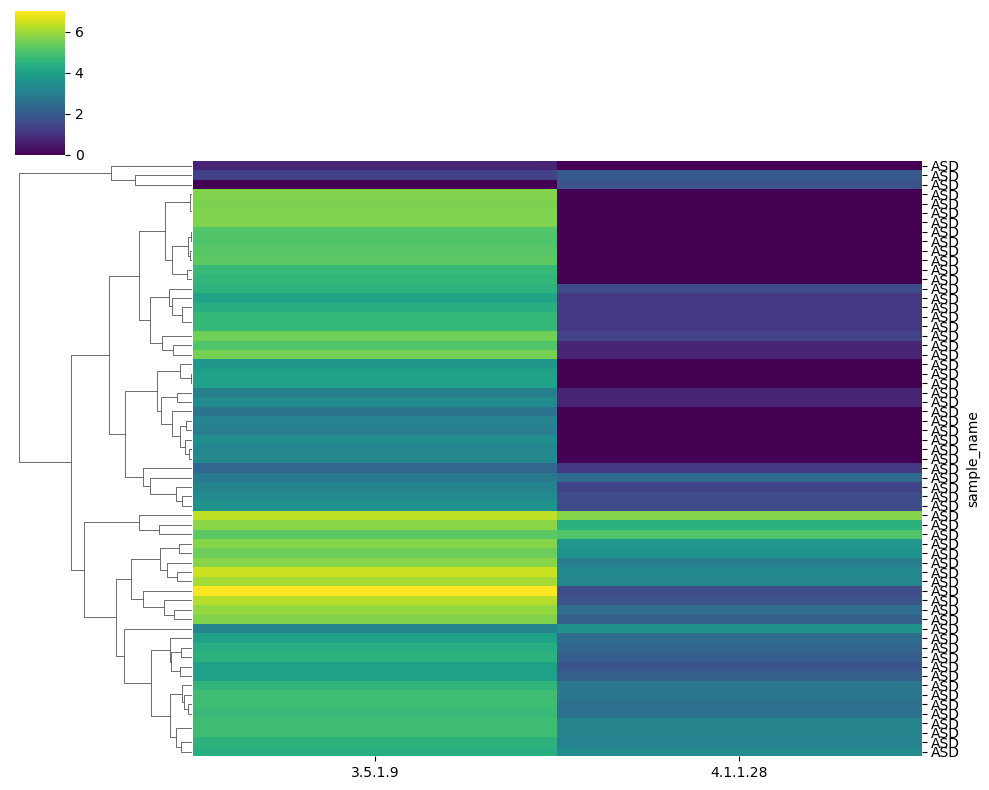

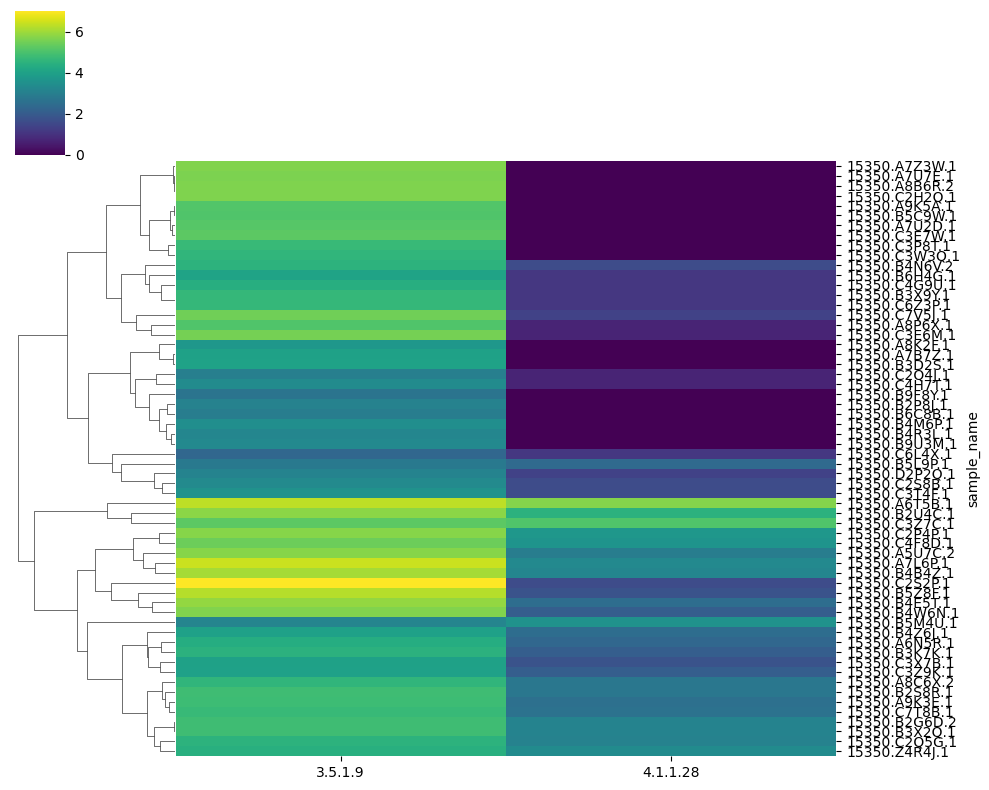

In [10]:

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Filter for just the specific EC values
specific_ec_values = ["3.5.1.9", "4.1.1.28"]
filtered_ec_df_asd_specific = filtered_ec_df_asd[specific_ec_values]

# Log-transform the filtered data to handle zeros
logged_df_asd_specific = np.log1p(filtered_ec_df_asd_specific)

# Retrieve the 'dx' values for the rows (though they should all be "ASD" now)
row_labels = metadata_df.loc[logged_df_asd_specific.index, 'dx']

# Create the cluster map with annotations
cluster_map = sns.clustermap(logged_df_asd_specific, cmap="viridis", cbar=True,
                             xticklabels=specific_ec_values, yticklabels=row_labels,
                             figsize=(10, 8), col_cluster=False)  # Disable column clustering

# Extract the row linkage matrix
row_linkage = cluster_map.dendrogram_row.linkage

# Extract the first level clusters
first_level_clusters = fcluster(row_linkage, t=2, criterion='maxclust')

# Select the indices of samples in the first-level cluster 2
first_level_cluster_2_indices = logged_df_asd_specific.index[first_level_clusters == 2]

# Create a new linkage matrix and cluster map for the second-level clustering within cluster 2
second_level_df = logged_df_asd_specific.loc[first_level_cluster_2_indices]

# Perform clustering on the second-level DataFrame
second_cluster_map = sns.clustermap(second_level_df, cmap="viridis", cbar=True,
                                    xticklabels=specific_ec_values, yticklabels=first_level_cluster_2_indices,
                                    figsize=(10, 8), col_cluster=False)

# Extract the second-level row clusters
second_row_linkage = second_cluster_map.dendrogram_row.linkage
second_level_clusters = fcluster(second_row_linkage, t=2, criterion='maxclust')

# Add the second-level cluster labels to the metadata for exploration
metadata_with_second_level_clusters = metadata_df.loc[second_level_df.index].copy()
metadata_with_second_level_clusters['Second_Level_Cluster'] = second_level_clusters

# Show the updated metadata
metadata_with_second_level_clusters["Second_Level_Cluster"].value_counts()


In [11]:
# Identify all numeric columns in the metadata
numeric_columns = metadata_with_second_level_clusters.select_dtypes(include=[np.number]).columns
print(f"Numeric columns: {numeric_columns}")

from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U tests for all numeric columns
for column in numeric_columns:
    cluster1 = metadata_with_second_level_clusters[metadata_with_second_level_clusters['Second_Level_Cluster'] == 1][column].dropna()
    cluster2 = metadata_with_second_level_clusters[metadata_with_second_level_clusters['Second_Level_Cluster'] == 2][column].dropna()
    
    if not cluster1.empty and not cluster2.empty:
        stat, p = mannwhitneyu(cluster1, cluster2)
        print(f'Mann-Whitney U test for {column}:')
        print(f'Statistic: {stat}, p-value: {p}\n')
    else:
        print(f'Skipping {column} due to insufficient data.\n')


Numeric columns: Index(['ados_cosotot', 'ados_cosototrrtot', 'ados_rrtot', 'ageatfecalsample',
       'antibiotics_last_2weeks', 'breastfed_morethan1month',
       'constipation_2wk', 'currently_breastfeeding', 'diarrhea_2wk',
       'elevation', 'evergiven_formula', 'gestationalagebirth', 'host_age',
       'host_taxid', 'latitude', 'longitude', 'probiotics_2wks',
       'qiita_study_id', 'taxon_id', 'tube_id', 'vine_adapbehav_domstd',
       'vine_comtotal_domstd', 'vine_dlytotal_domstd', 'vine_mtrtotal_domstd',
       'vine_soctotal_domstd', 'Second_Level_Cluster'],
      dtype='object')
Mann-Whitney U test for ados_cosotot:
Statistic: 457.0, p-value: 0.8276642876861541

Mann-Whitney U test for ados_cosototrrtot:
Statistic: 459.0, p-value: 0.804854622891995

Mann-Whitney U test for ados_rrtot:
Statistic: 470.0, p-value: 0.6747182081874283

Mann-Whitney U test for ageatfecalsample:
Statistic: 341.5, p-value: 0.134967389590239

Mann-Whitney U test for antibiotics_last_2weeks:
Statisti

### RCLR

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Apply RCLR transformation
def rclr_transform(df):
    # Replace zeros with a small value to allow log transformation
    epsilon = 1e-5
    df_nonzero = df.replace(0, epsilon)
    
    # Log transform
    df_log = np.log(df_nonzero)
    
    # Calculate the mean of log values for each sample
    log_mean = df_log.mean(axis=1)
    
    # Subtract the log mean from each log-transformed value
    df_centered = df_log.sub(log_mean, axis=0)
    
    # Replace -inf values (resulting from log(epsilon)) with 0
    return df_centered.replace(-np.inf, 0)


In [13]:
import pandas as pd
import numpy as np
# this substracts the geometric mean instead of substracting the log mean from each value, which will produce a result similar to the matrix_rclr function found inside the Gemelli package.

def rclr_transform_geo(df):
    # Check for negative values
    if (df < 0).any().any():
        raise ValueError('DataFrame contains negative values')

    # Check for inf values
    if np.isinf(df).any().any():
        raise ValueError('DataFrame contains inf values')

    # Check for NaN values
    if df.isna().any().any():
        raise ValueError('DataFrame contains NaN values')

    # Replace zeros with a small value to allow log transformation
    epsilon = 1e-5
    df_nonzero = df.replace(0, epsilon)

    # Perform closure operation
    df_closed = df_nonzero.div(df_nonzero.sum(axis=1), axis=0)

    # Log transform
    df_log = np.log(df_closed)

    # Calculate geometric mean for each sample
    geom_mean = df_log.mean(axis=1)

    # Center log-ratios by subtracting the geometric mean
    df_centered = df_log.sub(geom_mean, axis=0)

    # Replace -inf values (resulting from log(epsilon)) with NaN
    df_centered = df_centered.replace(-np.inf, np.nan)

    return df_centered

# Example usage:
# df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 0, 6], 'C': [7, 8, 9]})
# result = rclr_transform(df)
# print(result)

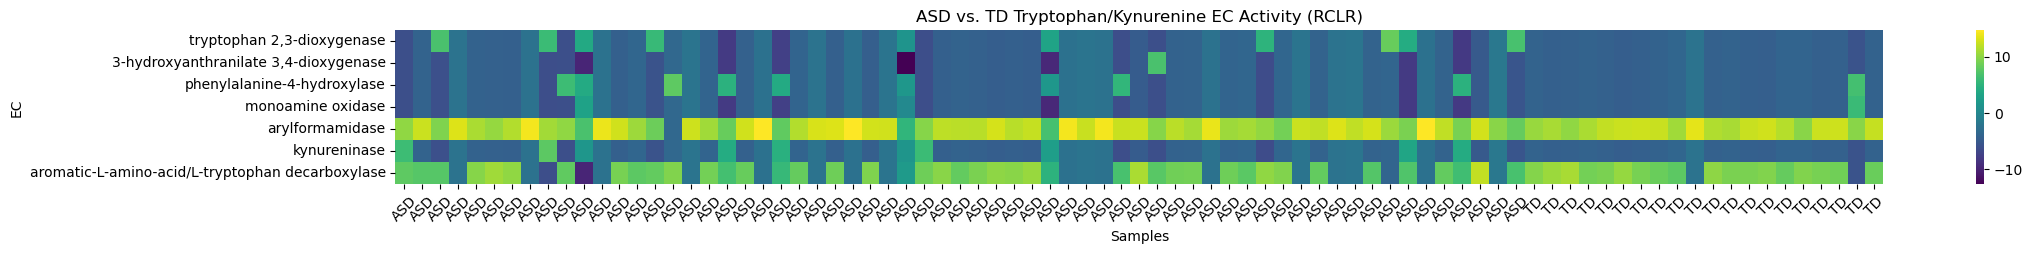

In [14]:

# Apply RCLR transformation to the data
rclr_df = rclr_transform(sorted_filtered_ec_df)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# Retrieve the 'dx' values for the rows
row_labels = metadata_df.loc[rclr_df.index, 'dx']

# Ensure the order of column labels matches the rclr_df columns
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# Transpose the DataFrame for the heatmap
transposed_rclr_df = rclr_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

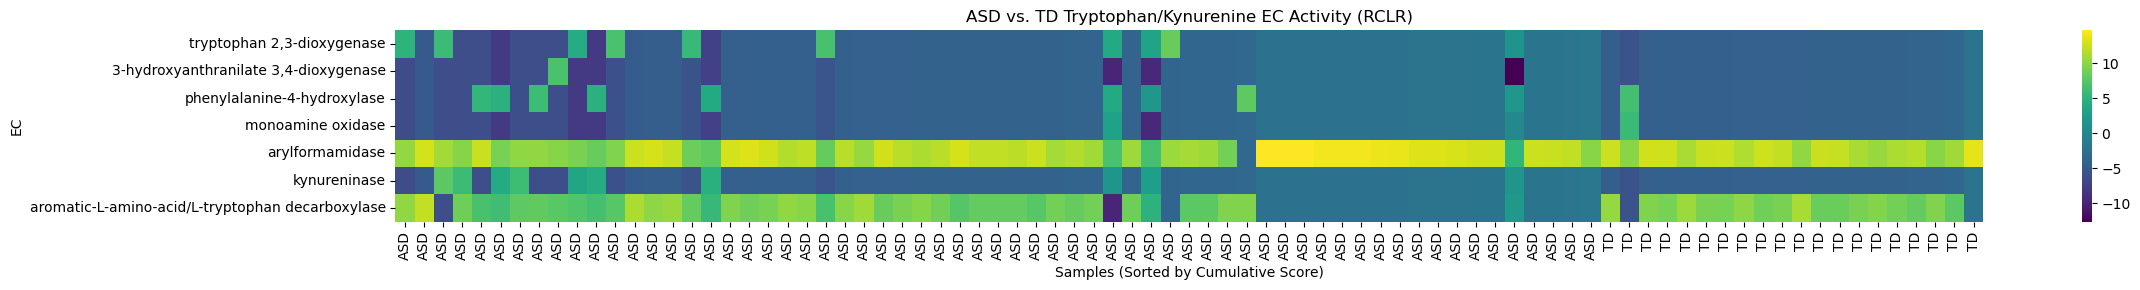

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Apply RCLR transformation
def rclr_transform(df):
    # Replace zeros with a small value to allow log transformation
    epsilon = 1e-5
    df_nonzero = df.replace(0, epsilon)
    # Log transform
    df_log = np.log(df_nonzero)
    # Calculate the mean of log values for each sample
    log_mean = df_log.mean(axis=1)
    # Subtract the log mean from each log-transformed value
    df_centered = df_log.sub(log_mean, axis=0)
    # Replace -inf values (resulting from log(epsilon)) with 0
    return df_centered.replace(-np.inf, 0)

# Apply RCLR transformation to the data
rclr_df = rclr_transform(sorted_filtered_ec_df)

# Calculate cumulative activity score (using absolute values)
cumulative_score = rclr_df.abs().sum(axis=1)

# Add dx information and cumulative score to the DataFrame
rclr_df['dx'] = metadata_df.loc[rclr_df.index, 'dx']
rclr_df['cumulative_score'] = cumulative_score

# Sort samples within each group (ASD and TD) by cumulative score
asd_samples = rclr_df[rclr_df['dx'] == 'ASD'].sort_values('cumulative_score', ascending=False)
td_samples = rclr_df[rclr_df['dx'] == 'TD'].sort_values('cumulative_score', ascending=False)

# Combine sorted ASD and TD samples
sorted_rclr_df = pd.concat([asd_samples, td_samples])

# Remove auxiliary columns before transposing
sorted_rclr_df = sorted_rclr_df.drop(['dx', 'cumulative_score'], axis=1)

# Transpose the DataFrame for the heatmap
transposed_rclr_df = sorted_rclr_df.T

# Retrieve the 'EC' values for the rows (former columns)
row_labels = [info[info['EC'] == col].index[0] for col in transposed_rclr_df.index]

# Retrieve the 'dx' values for the rows
row_labels_plot = metadata_df.loc[rclr_df.index, 'dx']

# Create the heatmap
plt.figure(figsize=(24, 3))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=row_labels_plot, yticklabels=row_labels)

# Add a horizontal line to separate ASD and TD samples
# plt.axvline(x=asd_samples.shape[0], color='red', linewidth=2)

# Customize the plot
plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples (Sorted by Cumulative Score)")
plt.ylabel("EC")

# Add text labels for ASD and TD
# plt.text(asd_samples.shape[0]/2, -1, 'ASD', ha='center', va='bottom')
# plt.text(asd_samples.shape[0] + td_samples.shape[0]/2, -1, 'TD', ha='center', va='bottom')

plt.tight_layout()
plt.show()

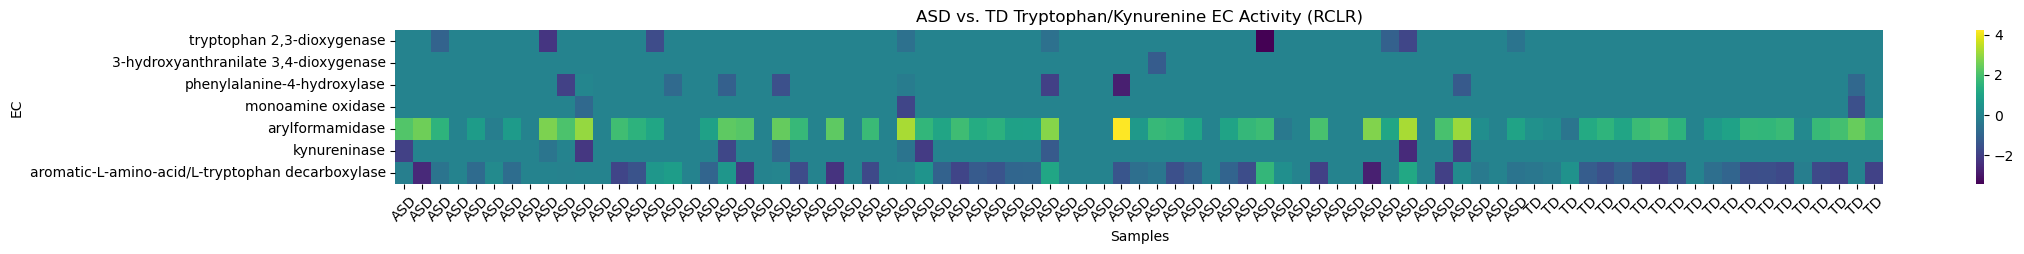

Shape of the data: (83, 7)
Number of NaN values after replacement: 0
Min value: -3.4315502919778105
Max value: 4.210238667681556


In [16]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from gemelli.preprocessing import matrix_rclr

# # Apply RCLR transformation using gemelli's matrix_rclr function
# rclr_df = pd.DataFrame(
#     matrix_rclr(sorted_filtered_ec_df.values),
#     index=sorted_filtered_ec_df.index,
#     columns=sorted_filtered_ec_df.columns
# )

# # Retrieve the 'EC' values for the columns and match them to the default index in info
# column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# # Retrieve the 'dx' values for the rows
# row_labels = metadata_df.loc[rclr_df.index, 'dx']

# # Ensure the order of column labels matches the rclr_df columns
# column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# # Transpose the DataFrame for the heatmap
# transposed_rclr_df = rclr_df.T

# # Retrieve the transposed labels
# transposed_row_labels = column_labels  # Now the columns become rows
# transposed_column_labels = row_labels  # Now the rows become columns

# # Create the heatmap with annotations
# plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
# sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
#             xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
# plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
# plt.xlabel("Samples")
# plt.ylabel("EC")
# plt.xticks(rotation=45)  # Rotate x labels for better readability
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# Retrieve the 'dx' values for the rows
row_labels = metadata_df.loc[rclr_df.index, 'dx']

# Ensure the order of column labels matches the rclr_df columns
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# Transpose the DataFrame for the heatmap
transposed_rclr_df = rclr_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

# Print some diagnostic information
print(f"Shape of the data: {rclr_df.shape}")
print(f"Number of NaN values after replacement: {rclr_df.isna().sum().sum()}")
print(f"Min value: {rclr_df.min().min()}")
print(f"Max value: {rclr_df.max().max()}")

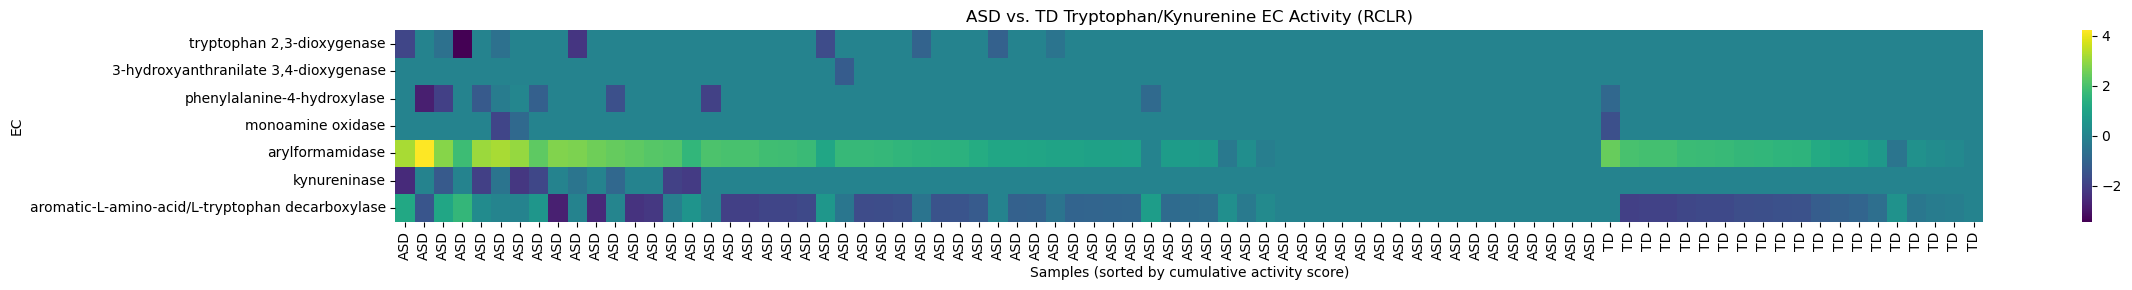

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Calculate cumulative activity score (using absolute values)
cumulative_score = rclr_df.abs().sum(axis=1)

# Add dx information and cumulative score to the DataFrame
rclr_df['dx'] = metadata_df.loc[rclr_df.index, 'dx']
rclr_df['cumulative_score'] = cumulative_score

# Sort samples within each group (ASD and TD) by cumulative score
asd_samples = rclr_df[rclr_df['dx'] == 'ASD'].sort_values('cumulative_score', ascending=False)
td_samples = rclr_df[rclr_df['dx'] == 'TD'].sort_values('cumulative_score', ascending=False)

# Combine sorted ASD and TD samples
sorted_rclr_df = pd.concat([asd_samples, td_samples])

# Remove auxiliary columns before transposing
sorted_rclr_df = sorted_rclr_df.drop(['dx', 'cumulative_score'], axis=1)

# Transpose the DataFrame for the heatmap
transposed_rclr_df = sorted_rclr_df.T

# Retrieve the 'EC' values for the rows (former columns)
row_labels = [info[info['EC'] == col].index[0] for col in transposed_rclr_df.index]

# Retrieve the 'dx' values for the rows
row_labels_plot = metadata_df.loc[rclr_df.index, 'dx']

# Create the heatmap
plt.figure(figsize=(24, 3))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=row_labels_plot, yticklabels=row_labels)


# Customize the plot
plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples (sorted by cumulative activity score)")
plt.ylabel("EC")

plt.tight_layout()
plt.show()

/tmp/ipykernel_432436/3308466572.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


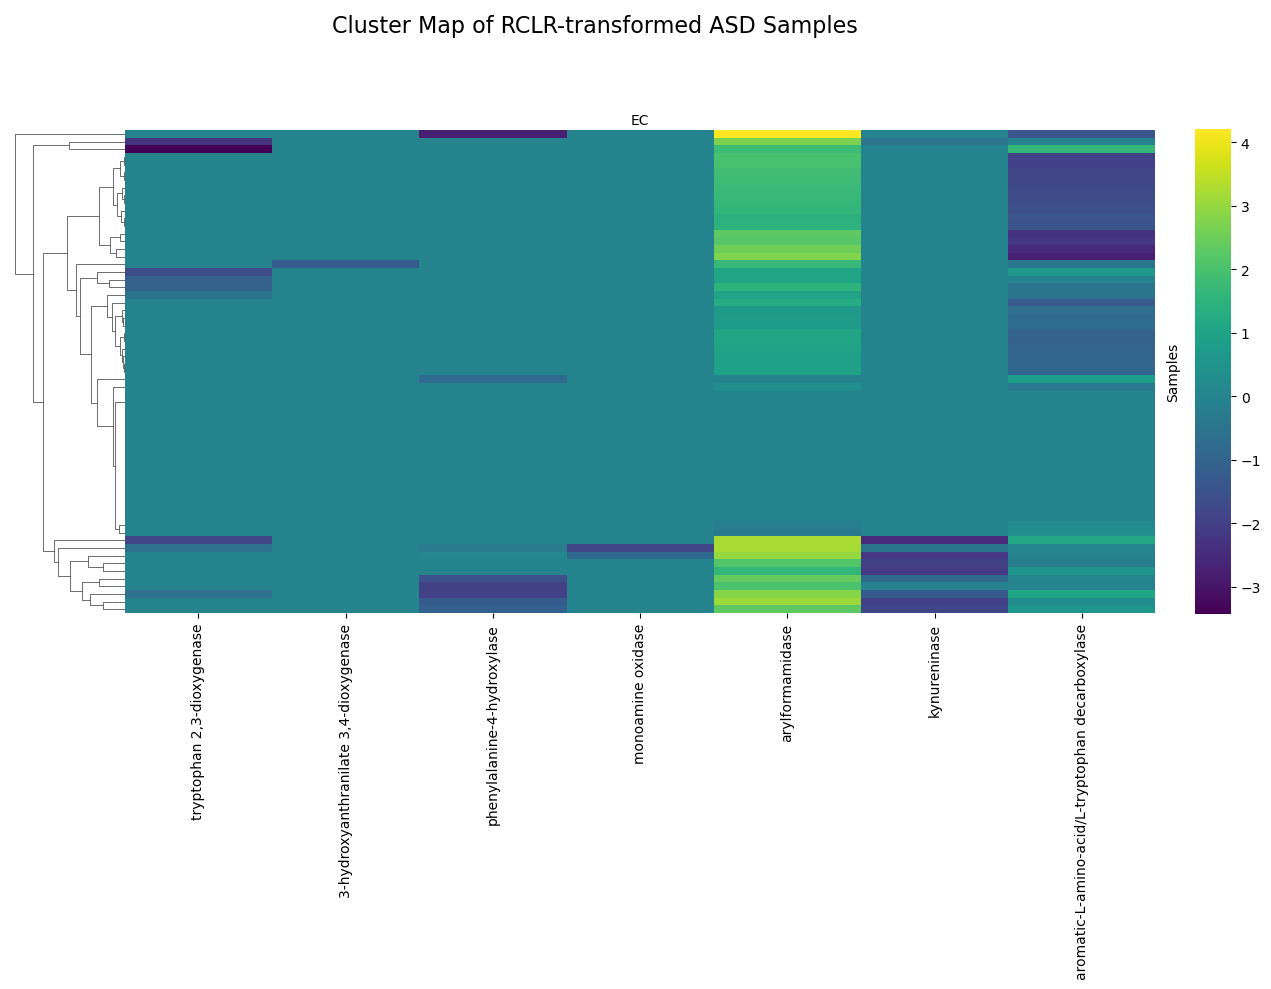

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr
from scipy.cluster.hierarchy import linkage

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Remove rows and columns that are all zeros
filtered_ec_df_asd = filtered_ec_df_asd.loc[(filtered_ec_df_asd != 0).any(axis=1), (filtered_ec_df_asd != 0).any(axis=0)]

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df_asd = pd.DataFrame(
    matrix_rclr(filtered_ec_df_asd.values),
    index=filtered_ec_df_asd.index,
    columns=filtered_ec_df_asd.columns
)

# Replace NaN and infinite values with a small epsilon
epsilon = 0
rclr_df_asd = rclr_df_asd.replace([np.inf, -np.inf], np.nan).fillna(epsilon)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df_asd.columns]

# Create the cluster map
g = sns.clustermap(rclr_df_asd, 
                   cmap="viridis", 
                   cbar=True,
                   xticklabels=column_labels, 
                   yticklabels=False,  # Hide row labels for better visibility
                   figsize=(12, 10), 
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(1, .38, .03, .485),
                   col_cluster=False)  # Disable column clustering

# Adjust the plot
g.ax_heatmap.xaxis.set_label_position('top')
g.ax_heatmap.set_xlabel("EC")
g.ax_heatmap.set_ylabel("Samples")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.fig.suptitle("Cluster Map of RCLR-transformed ASD Samples", fontsize=16)
plt.tight_layout()
plt.show()


/tmp/ipykernel_432436/2350397214.py:53: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


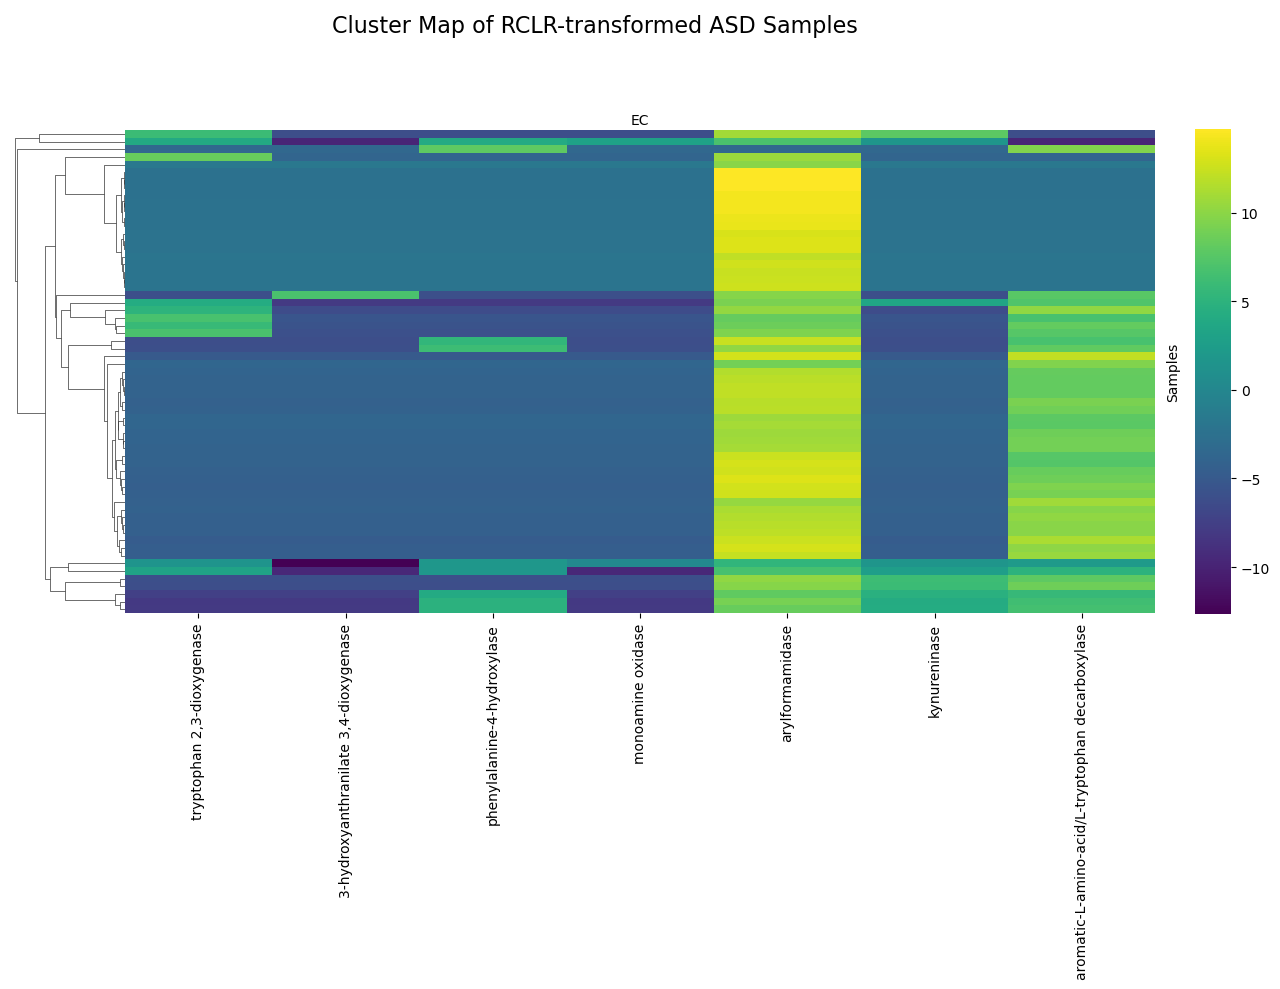

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# RCLR-transform the filtered data to handle zeros
rclr_df_asd = rclr_transform(filtered_ec_df_asd)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df_asd.columns]

# # Retrieve the 'dx' values for the rows (though they should all be "ASD" now)
# row_labels = metadata_df.loc[rclr_df_asd.index, 'dx']

# # Create the cluster map with annotations
# plt.figure(figsize=(12, 10))  # Adjusted figure size for the cluster map
# sns.clustermap(
#     rclr_df_asd, 
#     cmap="viridis",
#     cbar=True,
#     xticklabels=column_labels,
#     yticklabels=False,
#     col_cluster=False, 
#     cbar_pos=(1, .38, .03, .485))

# plt.suptitle("Cluster Map of Robust Centered Log-Ratio (RCLR) transformed ASD Samples", 
#              fontsize=12)
# plt.xlabel("EC")
# plt.ylabel("Samples")
# plt.xticks(rotation=45)  # Rotate x labels for better readability
# plt.show()

# Create the cluster map
g = sns.clustermap(rclr_df_asd, 
                   cmap="viridis", 
                   cbar=True,
                   xticklabels=column_labels, 
                   yticklabels=False,  # Hide row labels for better visibility
                   figsize=(12, 10), 
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(1, .38, .03, .485),
                   col_cluster=False)  # Disable column clustering

# Adjust the plot
g.ax_heatmap.xaxis.set_label_position('top')
g.ax_heatmap.set_xlabel("EC")
g.ax_heatmap.set_ylabel("Samples")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.fig.suptitle("Cluster Map of RCLR-transformed ASD Samples", fontsize=16)
plt.tight_layout()
plt.show()

### Comparing Custom RCLR vs. RCLR-Gemelli

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster, dendrogram
from scipy.stats import chi2_contingency
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns



In [34]:


# Custom RCLR function
def rclr_transform(df):
    epsilon = 1e-5
    df_nonzero = df.replace(0, epsilon)
    df_log = np.log(df_nonzero)
    log_mean = df_log.mean(axis=1)
    df_centered = df_log.sub(log_mean, axis=0)
    return df_centered.replace(-np.inf, 0)

# Filter samples and apply transformations
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Custom RCLR
custom_rclr_df = rclr_transform(filtered_ec_df_asd)

# Gemelli RCLR
gemelli_rclr_df = pd.DataFrame(
    matrix_rclr(filtered_ec_df_asd.values),
    index=filtered_ec_df_asd.index,
    columns=filtered_ec_df_asd.columns
)
gemelli_rclr_df = gemelli_rclr_df.replace([np.inf, -np.inf], np.nan).fillna(0)


In [35]:

from scipy.cluster.hierarchy import linkage

# Perform hierarchical clustering for both methods
custom_linkage = linkage(custom_rclr_df, method='ward')
gemelli_linkage = linkage(gemelli_rclr_df, method='ward')

# Function to get cluster assignments
def get_clusters(linkage_matrix, n_clusters):
    return fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Get cluster assignments for both methods (let's use 5 clusters as an example)
n_clusters = 5
custom_clusters = get_clusters(custom_linkage, n_clusters)
gemelli_clusters = get_clusters(gemelli_linkage, n_clusters)


In [36]:

custom_cluster_df = pd.DataFrame({'sample_id': custom_rclr_df.index, 'custom_cluster': custom_clusters})
gemelli_cluster_df = pd.DataFrame({'sample_id': gemelli_rclr_df.index, 'gemelli_cluster': gemelli_clusters})

# Merge cluster assignments
cluster_comparison = pd.merge(custom_cluster_df, gemelli_cluster_df, on='sample_id')

# Print sample IDs for each cluster in both methods
print("Custom RCLR Clusters:")
for i in range(1, n_clusters + 1):
    print(f"Cluster {i}: {', '.join(cluster_comparison[cluster_comparison['custom_cluster'] == i]['sample_id'])}")

print("\nGemelli RCLR Clusters:")
for i in range(1, n_clusters + 1):
    print(f"Cluster {i}: {', '.join(cluster_comparison[cluster_comparison['gemelli_cluster'] == i]['sample_id'])}")


Custom RCLR Clusters:
Cluster 1: 15350.A7B7Z.1, 15350.A7U2D.1, 15350.A7U7E.1, 15350.A7Z3W.1, 15350.A8K2F.1, 15350.A9K5A.1, 15350.B2P8J.1, 15350.B3D2S.1, 15350.B4M6P.1, 15350.B4Q5Y.1, 15350.B4R3L.1, 15350.B5C9W.1, 15350.B9F8Y.1, 15350.B9U3M.1, 15350.C2H2Q.1, 15350.C3P8T.1, 15350.C3W3Q.1
Cluster 2: 15350.A7L6P.1, 15350.A8B6R.2, 15350.B6C8B.1, 15350.C3E7W.1
Cluster 3: 15350.A5U7C.2, 15350.B2G6D.2, 15350.C2S2P.1, 15350.C3X7B.1, 15350.C6V2C.1, 15350.C7T8B.1
Cluster 4: 15350.A6N5R.1, 15350.A6T5B.1, 15350.A8C6X.2, 15350.A8P6X.1, 15350.B2S8R.1, 15350.B2U4C.1, 15350.B3K7K.1, 15350.B3X9Y.1, 15350.B4B4Z.1, 15350.B4E5T.1, 15350.B4N6V.2, 15350.B4W6N.1, 15350.B4Z6J.1, 15350.B5M4U.1, 15350.B5Z8F.1, 15350.B6H4G.1, 15350.C2Q4J.1, 15350.C2Q5G.1, 15350.C2S8B.1, 15350.C3E6M.1, 15350.C3T4F.1, 15350.C3V4G.1, 15350.C4F8D.1, 15350.C4G9U.1, 15350.C4H7T.1, 15350.C6Z3P.1, 15350.C7V5J.1, 15350.D2P2Q.1
Cluster 5: 15350.A9K3E.1, 15350.B3X2Q.1, 15350.B5L9P.1, 15350.C2P4P.1, 15350.C3Z7C.1, 15350.C3Z9K.1, 15350.C6L4X.

In [37]:

# Adjusted Rand Index
ari = adjusted_rand_score(custom_clusters, gemelli_clusters)
print(f"\nAdjusted Rand Index: {ari}")

# Adjusted Mutual Information
ami = adjusted_mutual_info_score(custom_clusters, gemelli_clusters)
print(f"Adjusted Mutual Information: {ami}")



Adjusted Rand Index: 0.4635097019262115
Adjusted Mutual Information: 0.5207375054758783


In [38]:

contingency_table = pd.crosstab(cluster_comparison['custom_cluster'], cluster_comparison['gemelli_cluster'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test of independence:")
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")



Chi-square test of independence:
Chi-square statistic: 98.33116883116881
p-value: 7.111136858031093e-14


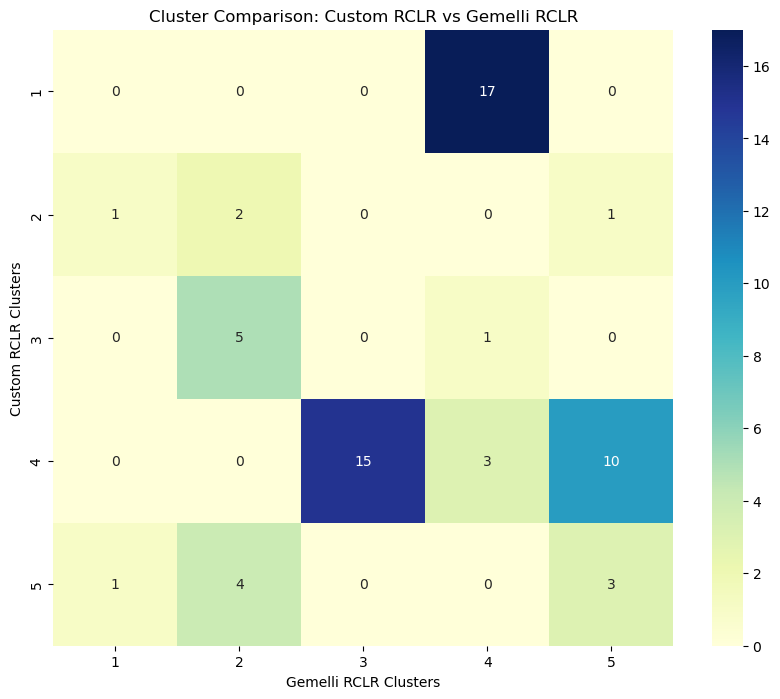

In [39]:

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Cluster Comparison: Custom RCLR vs Gemelli RCLR')
plt.xlabel('Gemelli RCLR Clusters')
plt.ylabel('Custom RCLR Clusters')
plt.show()


In [40]:

print("\nConclusion:")
if p_value < 0.05:
    print("The clustering results from Custom RCLR and Gemelli RCLR are significantly different (p < 0.05).")
else:
    print("There is no significant evidence that the clustering results from Custom RCLR and Gemelli RCLR are different (p >= 0.05).")

print(f"\nAdjusted Rand Index (ARI) of {ari:.4f} suggests {'high' if ari > 0.7 else 'moderate' if ari > 0.5 else 'low'} similarity between the clusterings.")
print(f"Adjusted Mutual Information (AMI) of {ami:.4f} indicates {'high' if ami > 0.7 else 'moderate' if ami > 0.5 else 'low'} shared information between the clusterings.")


Conclusion:
The clustering results from Custom RCLR and Gemelli RCLR are significantly different (p < 0.05).

Adjusted Rand Index (ARI) of 0.4635 suggests low similarity between the clusterings.
Adjusted Mutual Information (AMI) of 0.5207 indicates moderate shared information between the clusterings.


### Second Level Clustering

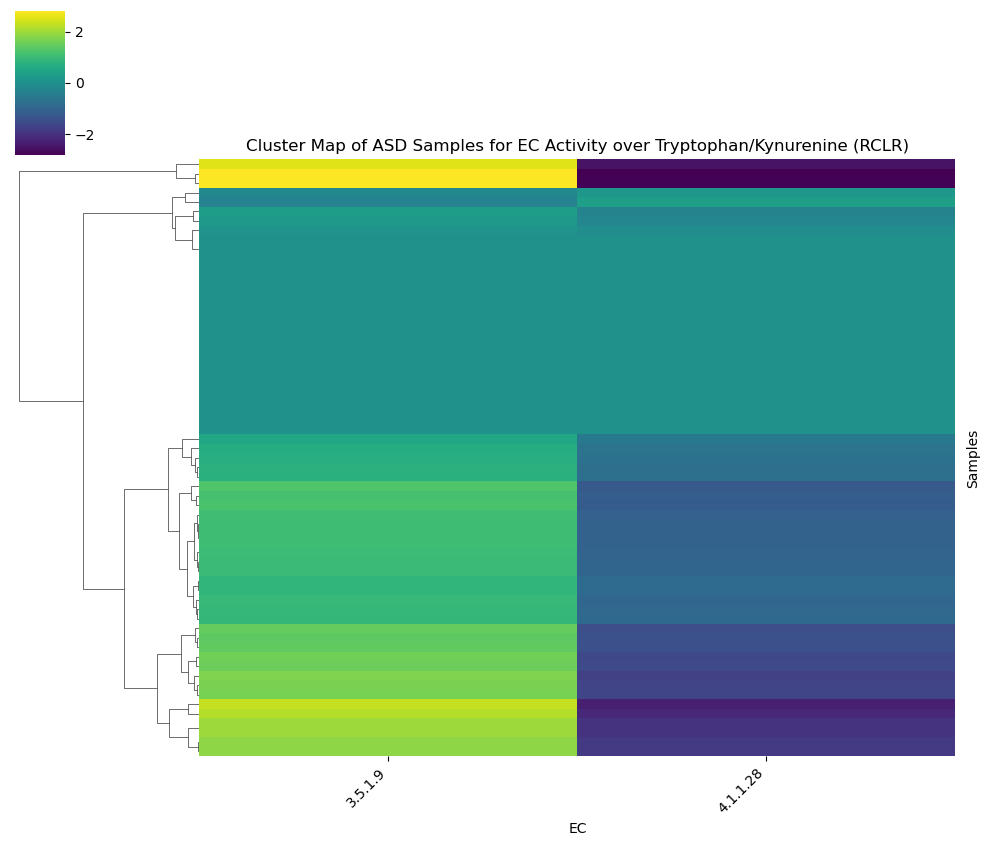

         3.5.1.9   4.1.1.28
count  63.000000  63.000000
mean    0.822336  -0.822336
std     0.831771   0.831771
min    -0.346574  -2.811105
25%     0.000000  -1.432525
50%     0.860571  -0.860571
75%     1.432525   0.000000
max     2.811105   0.346574

Correlation between Arylformamidase and L-tryptophan decarboxylase: -1.0000


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gemelli.preprocessing import matrix_rclr

# Assuming metadata_df, sorted_filtered_ec_df are already defined

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Filter for just the specific EC values
specific_ec_values = ["3.5.1.9", "4.1.1.28"]
filtered_ec_df_asd_specific = filtered_ec_df_asd[specific_ec_values]

# RCLR-transform the filtered data to handle zeros
rclr_df_asd_specific = pd.DataFrame(
    matrix_rclr(filtered_ec_df_asd_specific.values),
    index=filtered_ec_df_asd_specific.index,
    columns=filtered_ec_df_asd_specific.columns
)

# Replace infinite values with NaN and then with a small epsilon
epsilon = 0
rclr_df_asd_specific = rclr_df_asd_specific.replace([np.inf, -np.inf], np.nan).fillna(epsilon)

# Retrieve the 'dx' values for the rows (though they should all be "ASD" now)
row_labels = metadata_df.loc[rclr_df_asd_specific.index, 'dx']

# Create the cluster map with annotations
cluster_map = sns.clustermap(rclr_df_asd_specific, cmap="viridis", cbar=True,
                             xticklabels=specific_ec_values, yticklabels=False,
                             figsize=(10, 8), col_cluster=False)  

# Adjust the axes labels
cluster_map.ax_heatmap.set_xlabel("EC")
cluster_map.ax_heatmap.set_ylabel("Samples")
cluster_map.ax_heatmap.set_title("Cluster Map of ASD Samples for EC Activity over Tryptophan/Kynurenine (RCLR)")

# Rotate x-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Rotate y-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10)

# Show the plot
plt.show()


# Print summary statistics
print(rclr_df_asd_specific.describe())

# Calculate correlation
correlation = rclr_df_asd_specific["3.5.1.9"].corr(rclr_df_asd_specific["4.1.1.28"])
print(f"\nCorrelation between Arylformamidase and L-tryptophan decarboxylase: {correlation:.4f}")

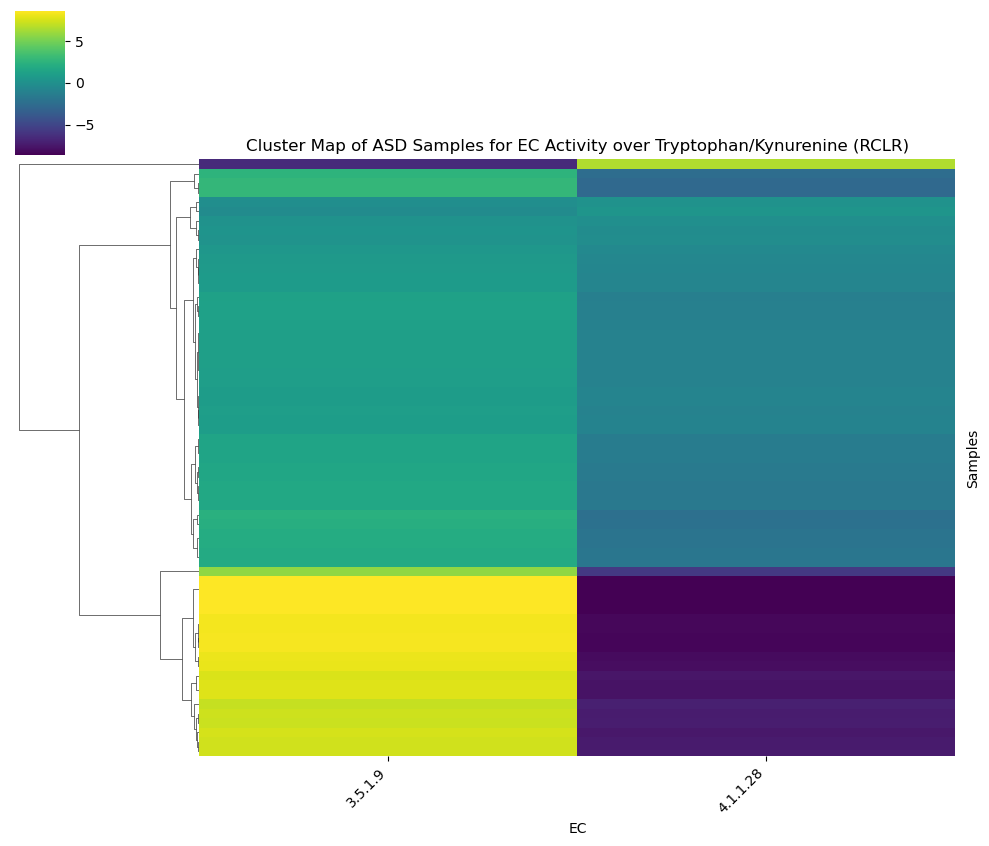

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter the samples to just "dx" == "ASD"
asd_samples = metadata_df[metadata_df['dx'] == 'ASD'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_samples]

# Filter for just the specific EC values
specific_ec_values = ["3.5.1.9", "4.1.1.28"]
filtered_ec_df_asd_specific = filtered_ec_df_asd[specific_ec_values]

# RCLR-transform the filtered data to handle zeros
rclr_df_asd_specific = rclr_transform(filtered_ec_df_asd_specific)

# Retrieve the 'dx' values for the rows (though they should all be "ASD" now)
row_labels = metadata_df.loc[rclr_df_asd_specific.index, 'dx']

# Create the cluster map with annotations
cluster_map = sns.clustermap(rclr_df_asd_specific, cmap="viridis", cbar=True,
                             xticklabels=specific_ec_values, yticklabels=False,
                             figsize=(10, 8), col_cluster=False)  

# Adjust the axes labels
cluster_map.ax_heatmap.set_xlabel("EC")
cluster_map.ax_heatmap.set_ylabel("Samples")
cluster_map.ax_heatmap.set_title("Cluster Map of ASD Samples for EC Activity over Tryptophan/Kynurenine (RCLR)")

# Rotate x-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Rotate y-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10)

# Show the plot
plt.show()


                       sum  count      mean
Second_Level_Cluster                       
1                     27.0     34  0.794118
2                     25.0     26  0.961538


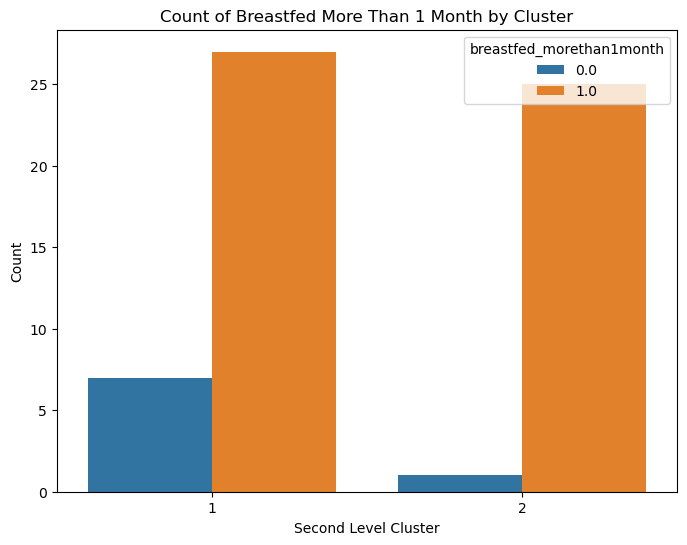

Contingency Table:
breastfed_morethan1month  0.0  1.0
Second_Level_Cluster              
1                           7   27
2                           1   25
Fisher's Exact Test for breastfed_morethan1month:
Odds Ratio: 6.481481481481482, p-value: 0.12159391478732365


In [43]:
# Calculate the count and proportion of 'breastfed_morethan1month' for each cluster
summary_stats_breastfed = metadata_with_second_level_clusters.groupby('Second_Level_Cluster')['breastfed_morethan1month'].agg(['sum', 'count', 'mean'])
print(summary_stats_breastfed)

import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot for the 'breastfed_morethan1month' column
plt.figure(figsize=(8, 6))
sns.countplot(x='Second_Level_Cluster', hue='breastfed_morethan1month', data=metadata_with_second_level_clusters)
plt.title('Count of Breastfed More Than 1 Month by Cluster')
plt.xlabel('Second Level Cluster')
plt.ylabel('Count')
plt.show()

from scipy.stats import fisher_exact

# Create a contingency table
contingency_table = pd.crosstab(metadata_with_second_level_clusters['Second_Level_Cluster'],
                                metadata_with_second_level_clusters['breastfed_morethan1month'])

print('Contingency Table:')
print(contingency_table)

# Perform Fisher's Exact Test
oddsratio, p_value = fisher_exact(contingency_table)
print(f"Fisher's Exact Test for breastfed_morethan1month:")
print(f'Odds Ratio: {oddsratio}, p-value: {p_value}')


In [44]:
metadata_with_second_level_clusters['breastfed_morethan1month']

sample_name
15350.A5U7C.2    1.0
15350.A6N5R.1    1.0
15350.A6T5B.1    1.0
15350.A7B7Z.1    1.0
15350.A7L6P.1    1.0
15350.A7U2D.1    0.0
15350.A7U7E.1    1.0
15350.A7Z3W.1    1.0
15350.A8B6R.2    1.0
15350.A8C6X.2    1.0
15350.A8K2F.1    1.0
15350.A8P6X.1    1.0
15350.A9K3E.1    1.0
15350.A9K5A.1    1.0
15350.B2G6D.2    1.0
15350.B2P8J.1    1.0
15350.B2S8R.1    1.0
15350.B2U4C.1    1.0
15350.B3D2S.1    1.0
15350.B3K7K.1    1.0
15350.B3X2Q.1    1.0
15350.B3X9Y.1    1.0
15350.B4B4Z.1    1.0
15350.B4E5T.1    1.0
15350.B4M6P.1    1.0
15350.B4N6V.2    1.0
15350.B4R3L.1    1.0
15350.B4W6N.1    1.0
15350.B4Z6J.1    1.0
15350.B5C9W.1    1.0
15350.B5L9P.1    1.0
15350.B5M4U.1    1.0
15350.B5Z8F.1    1.0
15350.B6C8B.1    0.0
15350.B6H4G.1    1.0
15350.B9F8Y.1    1.0
15350.B9U3M.1    1.0
15350.C2H2Q.1    1.0
15350.C2P4P.1    1.0
15350.C2Q4J.1    0.0
15350.C2Q5G.1    1.0
15350.C2S2P.1    1.0
15350.C2S8B.1    0.0
15350.C3E6M.1    1.0
15350.C3E7W.1    1.0
15350.C3P8T.1    0.0
15350.C3T4F.1    1.0
1

## ASD vs. ASD-TP

In [45]:
# Creating cumulative true positive score
metadata = md.to_dataframe()

# Filter for ASD cases first
asd_metadata = metadata[metadata['dx'] == 'ASD'].copy()

# Creating a df that indicates whether the sample is TP in one or more of the eye-tracking metrics
dx_eyetrack = pd.DataFrame(index=asd_metadata.index)
dx_eyetrack['dx_eyetrack'] = asd_metadata[['dx_compsocial', 'dx_geopref', 'dx_mtrtechno', 'dx_mtrtraffic', 'dx_outdoorplay']].apply(lambda x: 1 if 'TP' in x.values else 0, axis=1)

# Joining the dx_eyetrack DataFrame with the asd_metadata DataFrame
md_tp = asd_metadata.join(dx_eyetrack)

# Renaming labels in dx_eyetrack
md_tp['dx_eyetrack'] = md_tp['dx_eyetrack'].map({1: 'ASD-TP', 0: 'ASD'})

metadata_df = md_tp

# Display the value counts of the updated dx_eyetrack column
print(md_tp['dx_eyetrack'].value_counts())
print(metadata['dx'].value_counts())

ASD       34
ASD-TP    29
Name: dx_eyetrack, dtype: int64
ASD    63
TD     20
Name: dx, dtype: int64


<Figure size 1200x1000 with 0 Axes>

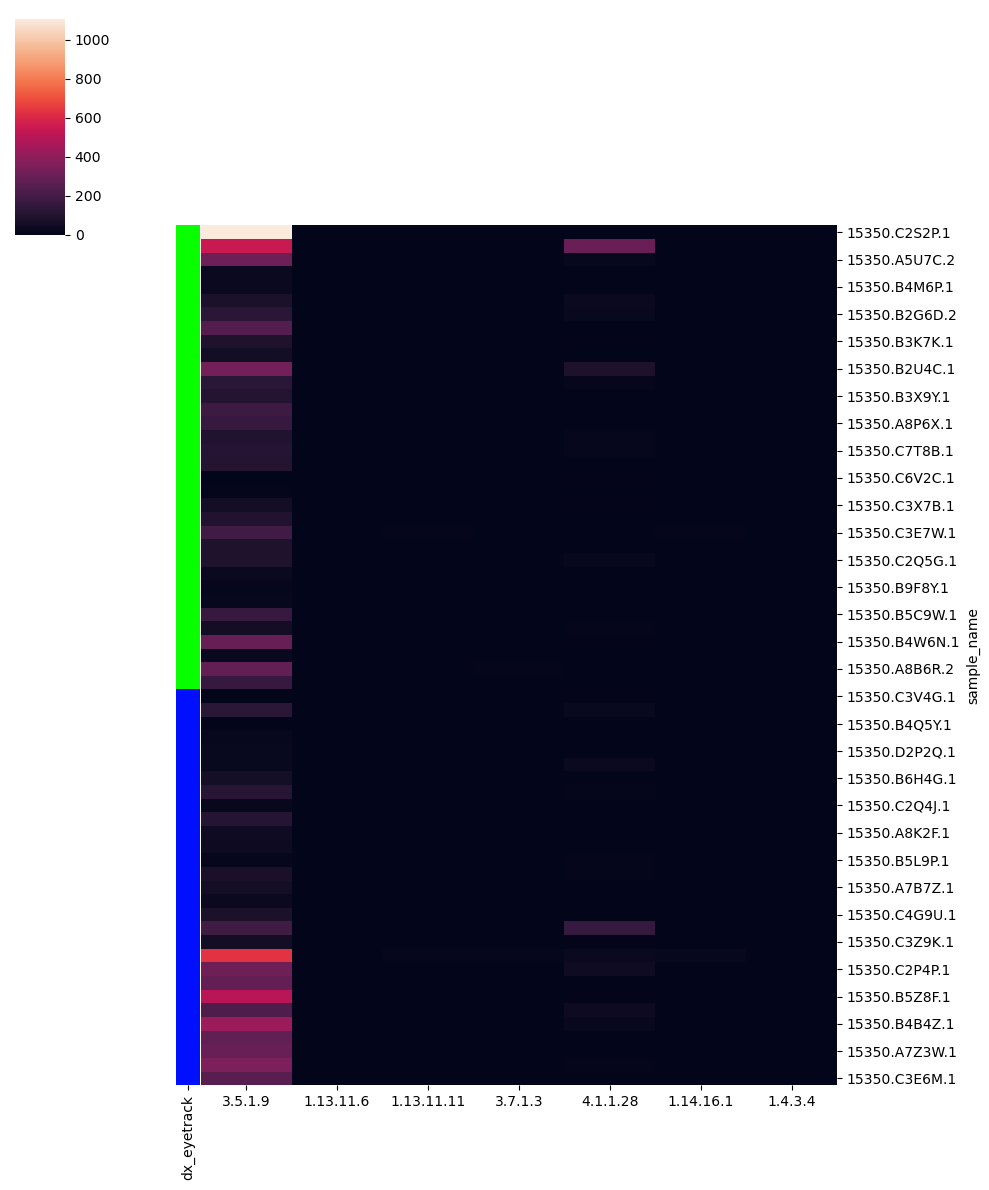

In [46]:
import biom
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np

# Load BIOM tables from the given paths
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')

# Convert the EC column values to a set for faster lookup
ec_info_values = set(info["EC"].values)

# Get the observation IDs from the BIOM table `ec`
ec_observation_ids = set(ec.ids(axis='observation'))

# Find the overlap
overlap = ec_info_values.intersection(ec_observation_ids)

# Filter the `ec` table to include only the overlapping observations
filtered_ec = ec.filter(overlap, axis='observation', inplace=False)

# Convert the filtered BIOM table to a DataFrame
filtered_ec_df = filtered_ec.to_dataframe(dense=True).T

# Filter metadata_df to include only samples present in filtered_ec_df
metadata_df_filtered = metadata_df[metadata_df.index.isin(filtered_ec_df.index)]

# Sort rows by 'dx_eyetrack'
sorted_metadata_df = metadata_df_filtered.sort_values('dx_eyetrack')
sorted_filtered_ec_df = filtered_ec_df.loc[sorted_metadata_df.index]

# Define clusters for rows (samples) within each 'dx' group
def cluster_within_groups(df, group_labels):
    sorted_idx = []
    unique_groups = group_labels.unique()
    for group in unique_groups:
        group_idx = group_labels[group_labels == group].index
        group_data = df.loc[group_idx]
        if len(group_idx) > 1:  # Only cluster if there's more than one sample
            kmeans = KMeans(n_clusters=2, random_state=0).fit(group_data)
            sorted_idx.extend(group_idx[np.argsort(kmeans.labels_)])
        else:
            sorted_idx.extend(group_idx)
    return sorted_idx

row_clusters = cluster_within_groups(sorted_filtered_ec_df, sorted_metadata_df["dx_eyetrack"])

# Group columns by 'Tryptophan Pathway' and sort within each group
grouped_columns = info.set_index('EC').loc[filtered_ec_df.columns, "Tryptophan Pathway"]
unique_pathways = grouped_columns.unique()
sorted_col_idx = []
for pathway in unique_pathways:
    pathway_cols = grouped_columns[grouped_columns == pathway].index
    pathway_data = filtered_ec_df[pathway_cols]
    if len(pathway_cols) > 1:  # Only cluster if there's more than one column
        col_linkage = linkage(pathway_data.T, method='ward')
        sorted_col_idx.extend(pathway_cols[leaves_list(col_linkage)])
    else:
        sorted_col_idx.extend(pathway_cols)

# Reorder the DataFrame using .loc for label-based indexing
reordered_df = sorted_filtered_ec_df.loc[row_clusters, sorted_col_idx]

# Relabel the x-axis using the original index names from info
info_indexed = info.set_index('EC')
column_labels = info_indexed.loc[reordered_df.columns].index
reordered_df.columns = column_labels

# Map the "dx_eyetrack" column to colors
unique_dx = sorted_metadata_df["dx_eyetrack"].unique()
color_palette = sns.color_palette("hsv", len(unique_dx))
dx_colors = dict(zip(unique_dx, color_palette))
row_colors = sorted_metadata_df["dx_eyetrack"].map(dx_colors).loc[row_clusters]

# Generate the cluster map
plt.figure(figsize=(12, 10))
sns.clustermap(reordered_df, row_cluster=False, col_cluster=False, figsize=(10, 12), row_colors=row_colors)
plt.show()

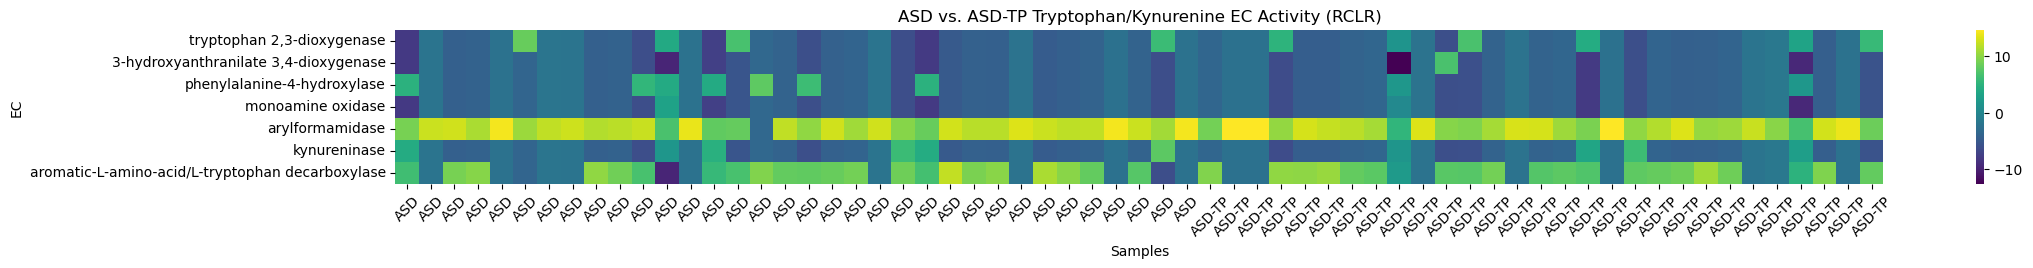

In [47]:

# Apply RCLR transformation to the data
rclr_df = rclr_transform(sorted_filtered_ec_df)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# Retrieve the 'dx' values for the rows
row_labels = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# Ensure the order of column labels matches the rclr_df columns
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# Transpose the DataFrame for the heatmap
transposed_rclr_df = rclr_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
plt.title("ASD vs. ASD-TP Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

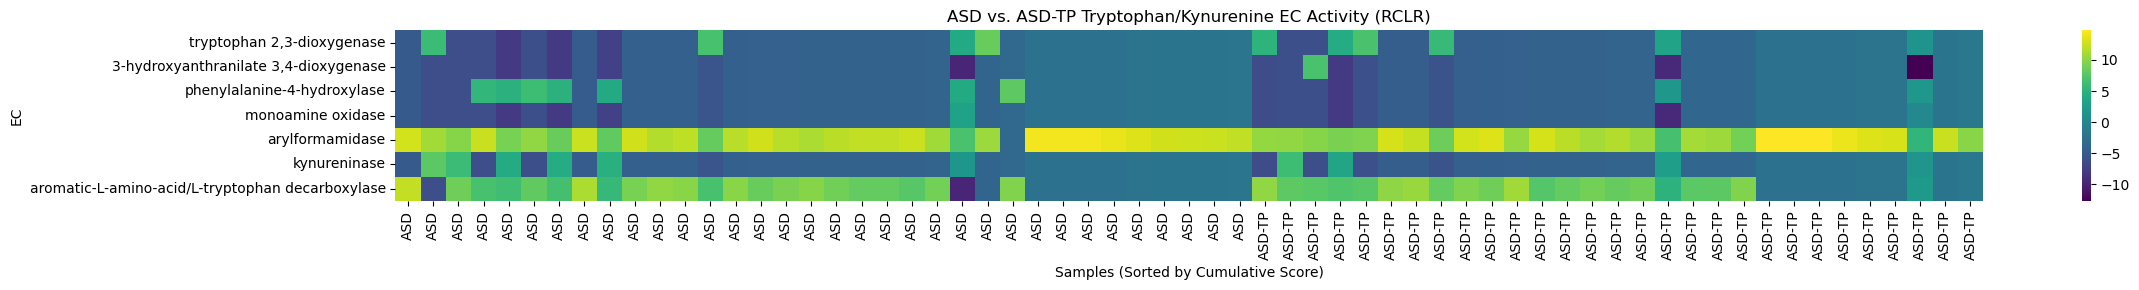

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Apply RCLR transformation
def rclr_transform(df):
    # Replace zeros with a small value to allow log transformation
    epsilon = 1e-5
    df_nonzero = df.replace(0, epsilon)
    # Log transform
    df_log = np.log(df_nonzero)
    # Calculate the mean of log values for each sample
    log_mean = df_log.mean(axis=1)
    # Subtract the log mean from each log-transformed value
    df_centered = df_log.sub(log_mean, axis=0)
    # Replace -inf values (resulting from log(epsilon)) with 0
    return df_centered.replace(-np.inf, 0)

# Apply RCLR transformation to the data
rclr_df = rclr_transform(sorted_filtered_ec_df)

# Calculate cumulative activity score (using absolute values)
cumulative_score = rclr_df.abs().sum(axis=1)

# Add dx information and cumulative score to the DataFrame
rclr_df['dx_eyetrack'] = metadata_df.loc[rclr_df.index, 'dx_eyetrack']
rclr_df['cumulative_score'] = cumulative_score

# Sort samples within each group (ASD and TD) by cumulative score
asd_samples = rclr_df[rclr_df['dx_eyetrack'] == 'ASD'].sort_values('cumulative_score', ascending=False)
tp_samples = rclr_df[rclr_df['dx_eyetrack'] == 'ASD-TP'].sort_values('cumulative_score', ascending=False)

# Combine sorted ASD and TD samples
sorted_rclr_df = pd.concat([asd_samples, tp_samples])

# Remove auxiliary columns before transposing
sorted_rclr_df = sorted_rclr_df.drop(['dx_eyetrack', 'cumulative_score'], axis=1)

# Transpose the DataFrame for the heatmap
transposed_rclr_df = sorted_rclr_df.T

# Retrieve the 'EC' values for the rows (former columns)
row_labels = [info[info['EC'] == col].index[0] for col in transposed_rclr_df.index]

# Retrieve the 'dx' values for the rows
row_labels_plot = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# Create the heatmap
plt.figure(figsize=(24, 3))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=row_labels_plot, yticklabels=row_labels)

# Add a horizontal line to separate ASD and TD samples
# plt.axvline(x=asd_samples.shape[0], color='red', linewidth=2)

# Customize the plot
plt.title("ASD vs. ASD-TP Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples (Sorted by Cumulative Score)")
plt.ylabel("EC")

# Add text labels for ASD and TD
# plt.text(asd_samples.shape[0]/2, -1, 'ASD', ha='center', va='bottom')
# plt.text(asd_samples.shape[0] + td_samples.shape[0]/2, -1, 'TD', ha='center', va='bottom')

plt.tight_layout()
plt.show()

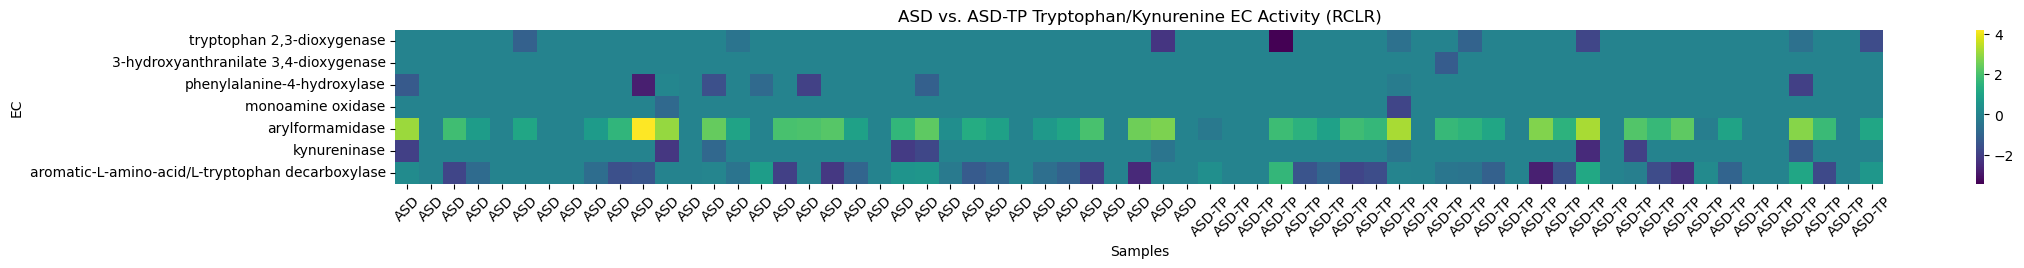

Shape of the data: (63, 7)
Number of NaN values after replacement: 0
Min value: -3.4315502919778105
Max value: 4.210238667681556


In [49]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from gemelli.preprocessing import matrix_rclr

# # Apply RCLR transformation using gemelli's matrix_rclr function
# rclr_df = pd.DataFrame(
#     matrix_rclr(sorted_filtered_ec_df.values),
#     index=sorted_filtered_ec_df.index,
#     columns=sorted_filtered_ec_df.columns
# )

# # Retrieve the 'EC' values for the columns and match them to the default index in info
# column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# # Retrieve the 'dx_eyetrack' values for the rows
# row_labels = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# # Ensure the order of column labels matches the rclr_df columns
# column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# # Transpose the DataFrame for the heatmap
# transposed_rclr_df = rclr_df.T

# # Retrieve the transposed labels
# transposed_row_labels = column_labels  # Now the columns become rows
# transposed_column_labels = row_labels  # Now the rows become columns

# # Create the heatmap with annotations
# plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
# sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
#             xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
# plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
# plt.xlabel("Samples")
# plt.ylabel("EC")
# plt.xticks(rotation=45)  # Rotate x labels for better readability
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# Retrieve the 'dx_eyetrack' values for the rows
row_labels = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# Ensure the order of column labels matches the rclr_df columns
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# Transpose the DataFrame for the heatmap
transposed_rclr_df = rclr_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
plt.title("ASD vs. ASD-TP Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

# Print some diagnostic information
print(f"Shape of the data: {rclr_df.shape}")
print(f"Number of NaN values after replacement: {rclr_df.isna().sum().sum()}")
print(f"Min value: {rclr_df.min().min()}")
print(f"Max value: {rclr_df.max().max()}")

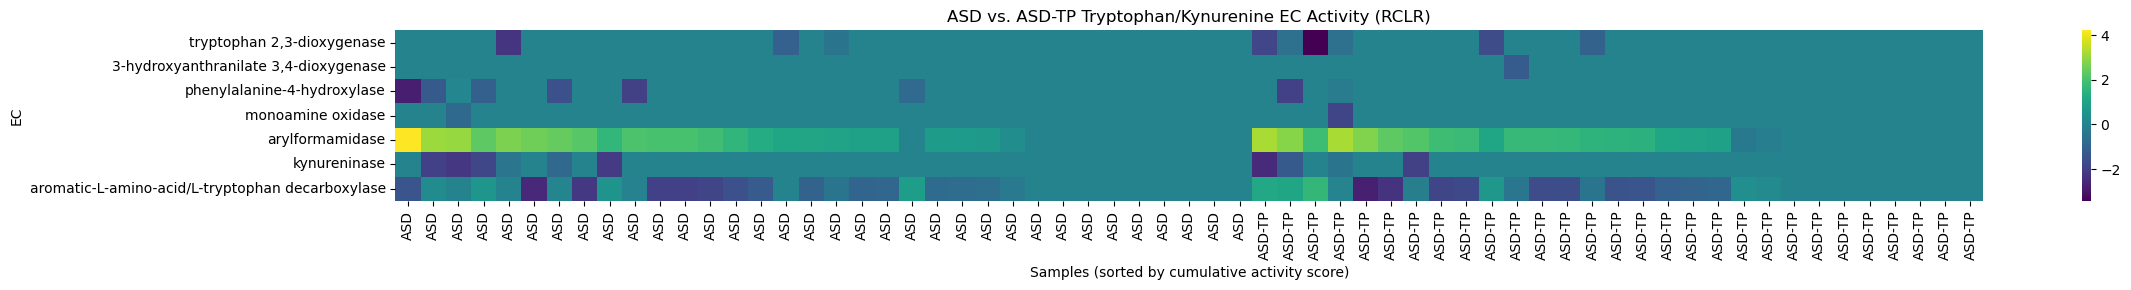

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Calculate cumulative activity score (using absolute values)
cumulative_score = rclr_df.abs().sum(axis=1)

# Add dx_eyetrack information and cumulative score to the DataFrame
rclr_df['dx_eyetrack'] = metadata_df.loc[rclr_df.index, 'dx_eyetrack']
rclr_df['cumulative_score'] = cumulative_score

# Sort samples within each group (ASD and TP) by cumulative score
asd_samples = rclr_df[rclr_df['dx_eyetrack'] == 'ASD'].sort_values('cumulative_score', ascending=False)
tp_samples = rclr_df[rclr_df['dx_eyetrack'] == 'ASD-TP'].sort_values('cumulative_score', ascending=False)

# Combine sorted ASD and TD samples
sorted_rclr_df = pd.concat([asd_samples, tp_samples])

# Remove auxiliary columns before transposing
sorted_rclr_df = sorted_rclr_df.drop(['dx_eyetrack', 'cumulative_score'], axis=1)

# Transpose the DataFrame for the heatmap
transposed_rclr_df = sorted_rclr_df.T

# Retrieve the 'EC' values for the rows (former columns)
row_labels = [info[info['EC'] == col].index[0] for col in transposed_rclr_df.index]

# Retrieve the 'dx' values for the rows
row_labels_plot = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# Create the heatmap
plt.figure(figsize=(24, 3))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=row_labels_plot, yticklabels=row_labels)


# Customize the plot
plt.title("ASD vs. ASD-TP Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples (sorted by cumulative activity score)")
plt.ylabel("EC")

plt.tight_layout()
plt.show()

/tmp/ipykernel_432436/377533132.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


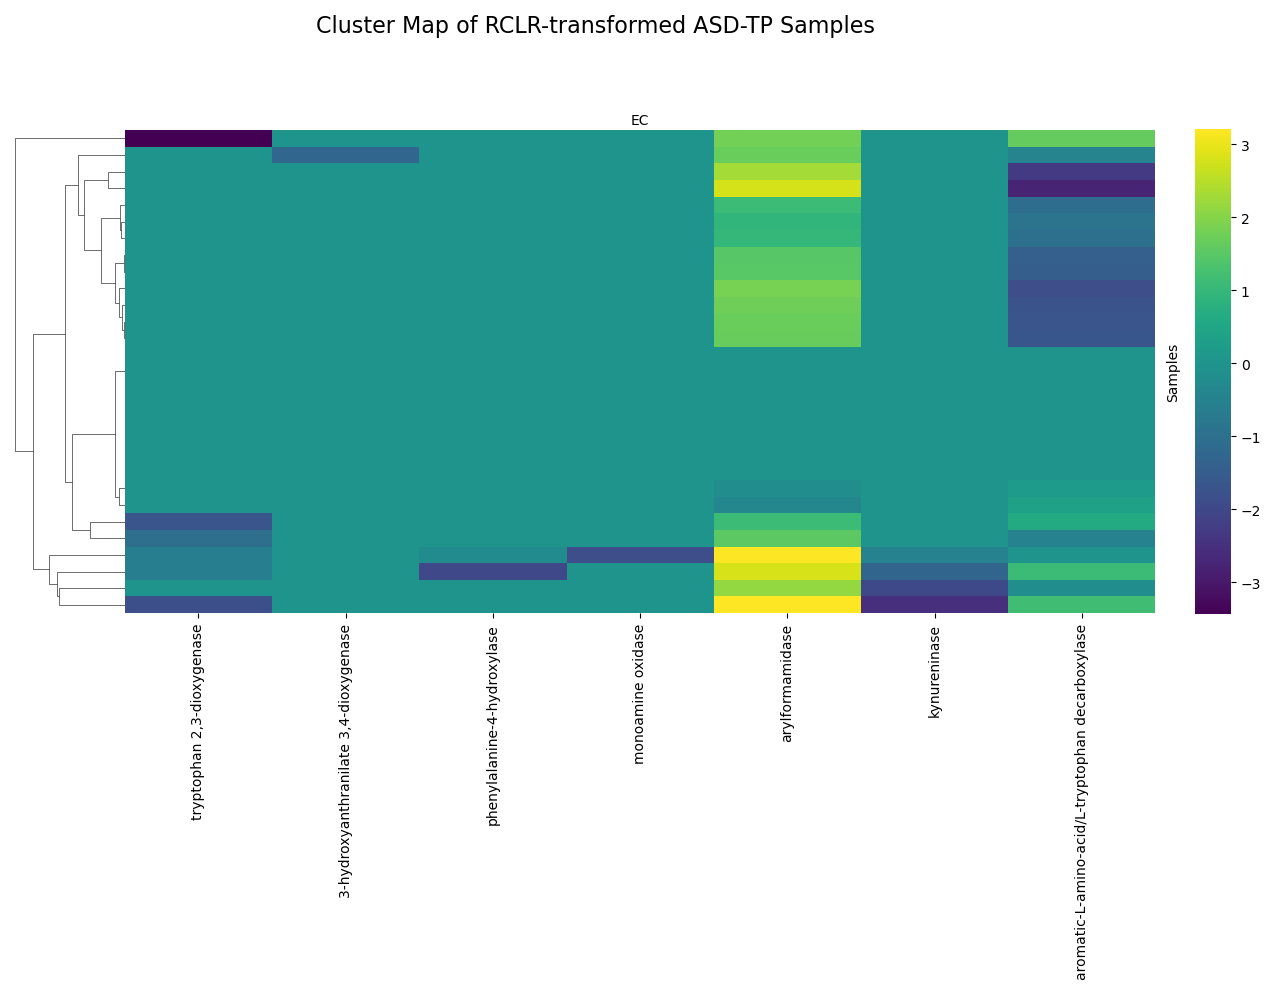

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr
from scipy.cluster.hierarchy import linkage

# Filter the samples to just "dx_eyetrack" == "ASD-TP"
asd_tp_samples = metadata_df[metadata_df['dx_eyetrack'] == 'ASD-TP'].index
filtered_ec_df_asd = sorted_filtered_ec_df.loc[asd_tp_samples]

# Remove rows and columns that are all zeros
filtered_ec_df_asd = filtered_ec_df_asd.loc[(filtered_ec_df_asd != 0).any(axis=1), (filtered_ec_df_asd != 0).any(axis=0)]

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df_asd = pd.DataFrame(
    matrix_rclr(filtered_ec_df_asd.values),
    index=filtered_ec_df_asd.index,
    columns=filtered_ec_df_asd.columns
)

# Replace NaN and infinite values with a small epsilon
epsilon = 0
rclr_df_asd = rclr_df_asd.replace([np.inf, -np.inf], np.nan).fillna(epsilon)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df_asd.columns]

# Create the cluster map
g = sns.clustermap(rclr_df_asd, 
                   cmap="viridis", 
                   cbar=True,
                   xticklabels=column_labels, 
                   yticklabels=False,  # Hide row labels for better visibility
                   figsize=(12, 10), 
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(1, .38, .03, .485),
                   col_cluster=False)  # Disable column clustering

# Adjust the plot
g.ax_heatmap.xaxis.set_label_position('top')
g.ax_heatmap.set_xlabel("EC")
g.ax_heatmap.set_ylabel("Samples")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.fig.suptitle("Cluster Map of RCLR-transformed ASD-TP Samples", fontsize=16)
plt.tight_layout()
plt.show()


## PCA

In [52]:
import biom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


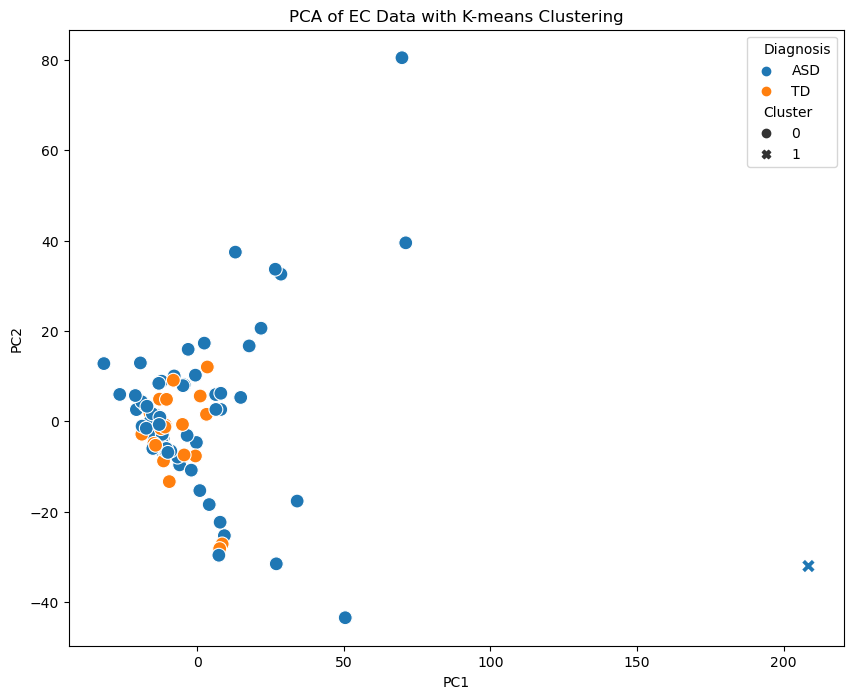

Percentage of ASD and TD samples in each cluster:
Diagnosis         ASD         TD
Cluster                         
0           75.609756  24.390244
1          100.000000   0.000000

Chi-square test p-value: 1.0

Top 10 contributing EC's:
             ec  importance
2002   4.2.1.59    0.063695
86     1.1.1.37    0.063436
2325   6.3.2.10    0.063161
1886   4.1.1.96    0.061997
1535   3.2.1.52    0.061935
946   2.4.99.17    0.061851
1451    3.1.4.-    0.061820
400     1.2.7.3    0.061596
819     2.3.2.5    0.061549
398    1.2.7.11    0.061483


In [53]:

# Load BIOM table
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')

# Convert the BIOM table to a DataFrame
ec_df = ec.to_dataframe(dense=True).T

# Load and prepare metadata
metadata_df = md.to_dataframe()
metadata_df = metadata_df.loc[ec_df.index]

# Ensure we only have ASD and TD samples
metadata_df = metadata_df[metadata_df['dx'].isin(['ASD', 'TD'])]
ec_df = ec_df.loc[metadata_df.index]

# Normalize the data
scaler = StandardScaler()
ec_df_scaled = pd.DataFrame(scaler.fit_transform(ec_df), index=ec_df.index, columns=ec_df.columns)

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(ec_df_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=ec_df_scaled.index)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(ec_df_scaled)

# Add cluster labels and diagnosis to PCA results
pca_df['Cluster'] = cluster_labels
pca_df['Diagnosis'] = metadata_df['dx']

# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Diagnosis', style='Cluster', s=100)
plt.title('PCA of EC Data with K-means Clustering')
plt.show()

# Calculate the percentage of ASD and TD samples in each cluster
cluster_diagnosis = pd.crosstab(pca_df['Cluster'], pca_df['Diagnosis'], normalize='index') * 100
print("Percentage of ASD and TD samples in each cluster:")
print(cluster_diagnosis)

# Perform statistical test (chi-square) to check if the distribution is significant
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(pca_df['Cluster'], pca_df['Diagnosis'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test p-value: {p_value}")

# Identify top contributing pathways
feature_importance = pd.DataFrame({
    'ec': ec_df_scaled.columns,
    'importance': np.abs(pca.components_[0]) + np.abs(pca.components_[1])
})
top_pathways = feature_importance.sort_values('importance', ascending=False).head(10)
print("\nTop 10 contributing EC's:")
print(top_pathways)

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming Cluster 0 is ASD and Cluster 1 is TD
# Convert diagnoses to binary (ASD: 1, TD: 0)
true_labels = (pca_df['Diagnosis'] == 'ASD').astype(int)
# Convert cluster labels to match (Cluster 0: 1, Cluster 1: 0)
predicted_labels = 1 - pca_df['Cluster']

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.7561
Recall: 0.9841
F1 Score: 0.8552
Accuracy: 0.7470


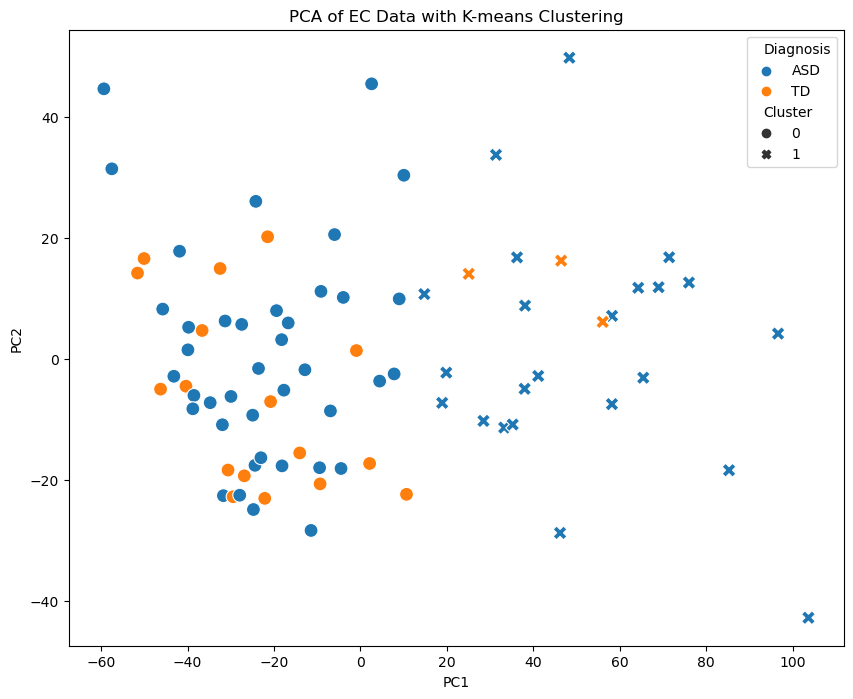

Percentage of ASD and TD samples in each cluster:
Diagnosis        ASD         TD
Cluster                        
0          70.175439  29.824561
1          88.461538  11.538462

Chi-square test p-value: 0.1259984773544527

Top 10 contributing EC's:
             ec  importance
1656  3.4.24.55    0.091376
122    1.1.1.57    0.090265
534     1.6.1.1    0.088269
1379   3.1.2.12    0.087955
2444   7.5.2.10    0.086979
545    1.7.1.15    0.086912
2114    5.1.2.3    0.086102
132    1.1.1.79    0.086026
134    1.1.1.81    0.086026
1179   2.7.2.15    0.085387


In [55]:

# Load BIOM table
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')

# Convert the BIOM table to a DataFrame
ec_df = ec.to_dataframe(dense=True).T

# Load and prepare metadata
metadata_df = md.to_dataframe()
metadata_df = metadata_df.loc[ec_df.index]

# Ensure we only have ASD and TD samples
metadata_df = metadata_df[metadata_df['dx'].isin(['ASD', 'TD'])]
ec_df = ec_df.loc[metadata_df.index]

# Log transform the data
# Adding a small constant to avoid log(0)
ec_df_log = np.log1p(ec_df)


# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(ec_df_log)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=ec_df_log.index)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(ec_df_log)

# Add cluster labels and diagnosis to PCA results
pca_df['Cluster'] = cluster_labels
pca_df['Diagnosis'] = metadata_df['dx']

# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Diagnosis', style='Cluster', s=100)
plt.title('PCA of EC Data with K-means Clustering')
plt.show()

# Calculate the percentage of ASD and TD samples in each cluster
cluster_diagnosis = pd.crosstab(pca_df['Cluster'], pca_df['Diagnosis'], normalize='index') * 100
print("Percentage of ASD and TD samples in each cluster:")
print(cluster_diagnosis)

# Perform statistical test (chi-square) to check if the distribution is significant
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(pca_df['Cluster'], pca_df['Diagnosis'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test p-value: {p_value}")

# Identify top contributing pathways
feature_importance = pd.DataFrame({
    'ec': ec_df_log.columns,
    'importance': np.abs(pca.components_[0]) + np.abs(pca.components_[1])
})
top_pathways = feature_importance.sort_values('importance', ascending=False).head(10)
print("\nTop 10 contributing EC's:")
print(top_pathways)

In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming Cluster 0 is ASD and Cluster 1 is TD
# Convert diagnoses to binary (ASD: 1, TD: 0)
true_labels = (pca_df['Diagnosis'] == 'ASD').astype(int)
# Convert cluster labels to match (Cluster 0: 1, Cluster 1: 0)
predicted_labels = 1 - pca_df['Cluster']

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.7018
Recall: 0.6349
F1 Score: 0.6667
Accuracy: 0.5181


In [57]:
pca_df.to_csv('/home/l1joseph/pierce_autism_2024/data/kegg/kegg_ec_pca.tsv', sep='\t', index =True)
pca_df.head()

,PC1,PC2,Cluster,Diagnosis
15350.A9K3E.1,-3.974000,10.193614,0,ASD
15350.C3P5B.1,-51.583240,14.224149,0,TD
15350.B4R3L.1,-29.956282,-6.180290,0,ASD
15350.C3V4G.1,-59.369219,44.684755,0,ASD
15350.C3Z7C.1,65.446186,-3.081113,1,ASD


In [58]:
# Identify samples diagnosed as TD but clustered as 1
td_clustered_as_1 = pca_df[(pca_df['Diagnosis'] == 'TD') & (pca_df['Cluster'] == 1)]

# Display the results
print("Samples diagnosed as TD but clustered as 1:")
print(td_clustered_as_1)

# Get the count of such samples
count_td_clustered_as_1 = len(td_clustered_as_1)
print(f"\nNumber of TD samples clustered as 1: {count_td_clustered_as_1}")

# Calculate the percentage of TD samples that were clustered as 1
total_td_samples = len(pca_df[pca_df['Diagnosis'] == 'TD'])
percentage_td_clustered_as_1 = (count_td_clustered_as_1 / total_td_samples) * 100

print(f"\nPercentage of TD samples clustered as 1: {percentage_td_clustered_as_1:.2f}%")

Samples diagnosed as TD but clustered as 1:
                     PC1        PC2  Cluster Diagnosis
15350.C3C5Z.1  46.447146  16.270757        1        TD
15350.C3Z8Y.1  25.063423  14.089927        1        TD
15350.B2M2J.1  56.062983   6.149479        1        TD

Number of TD samples clustered as 1: 3

Percentage of TD samples clustered as 1: 15.00%
